In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from scipy.stats import mannwhitneyu
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from lgde import Thresholding, LGDE, KNearestNeighbors, IKEA, LGDEWithCDlib, evaluate_prediction, error_analysis

Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool', 'wurlitzer', 'bayanpy', 'infomap'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw', 'pyclustering'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'infomap'}


In [2]:
plt.rcParams.update({'font.size': 18})

In [3]:
import scipy.stats

def mean_confidence_interval(data, confidence=0.95, digits=3):
    """Computes mean confidence interval for point."""
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return round(m,digits), round(m-h,digits), round(m+h, digits)

# Application to a benchmark hate speech dataset

## 1) Data input and pre-processing

In [4]:
# load fine-tuned embeddings for different dimensions
embedding_50d = pd.read_pickle("data/embeddings/glove_redgab_15_0.8_50d_1.0mu_df.pkl")
embedding_100d = pd.read_pickle("data/embeddings/glove_redgab_15_0.8_100d_1.0mu_df.pkl")
embedding_300d = pd.read_pickle("data/embeddings/glove_redgab_15_0.8_300d_1.0mu_df.pkl")

# load hyper-parameter tuning results
results_50d = pd.read_pickle("data/gs/gs_baselines_lgde_glove_redgab_15_0.8_50d_1.0mu_df.pkl")
results_100d = pd.read_pickle("data/gs/gs_baselines_lgde_glove_redgab_15_0.8_100d_1.0mu_df.pkl")
results_300d = pd.read_pickle("data/gs/gs_baselines_lgde_glove_redgab_15_0.8_300d_1.0mu_df.pkl")
results_tr = pd.read_pickle("data/gs/gs_textrank_redgab.pkl")
results_localmod_50d = pd.read_pickle("data/gs/gs_local_mod_50iter_glove_redgab_15_0.8_50d_1.0mu_df.pkl")
results_localmod_100d = pd.read_pickle("data/gs/gs_local_mod_50iter_glove_redgab_15_0.8_100d_1.0mu_df.pkl")
results_localmod_300d = pd.read_pickle("data/gs/gs_local_mod_50iter_glove_redgab_15_0.8_300d_1.0mu_df.pkl")

In [5]:
# retrieve word vectors at different dimensions
word_vecs_50d = np.zeros((embedding_50d["word_vector"].shape[0], embedding_50d["word_vector"][0].shape[0]))
for i in range(word_vecs_50d.shape[0]):
    word_vecs_50d[i, :] = embedding_50d["word_vector"][i]

word_vecs_100d = np.zeros((embedding_100d["word_vector"].shape[0], embedding_100d["word_vector"][0].shape[0]))
for i in range(word_vecs_100d.shape[0]):
    word_vecs_100d[i, :] = embedding_100d["word_vector"][i]

word_vecs_300d = np.zeros((embedding_300d["word_vector"].shape[0], embedding_300d["word_vector"][0].shape[0]))
for i in range(word_vecs_300d.shape[0]):
    word_vecs_300d[i, :] = embedding_300d["word_vector"][i]

In [6]:
# get word list
word_list = list(embedding_50d["word_string"])

# get document frequency
doc_freq = list(embedding_50d["doc_frequency"])

In [7]:
# load redgab data and split into train and test
with open("data/raw/redgab_pos_data.pkl", "rb") as handle:
    domain_data = pickle.load(handle)
    
X_train, X_test, y_train, y_test = train_test_split(
    domain_data.data,
    domain_data.target,
    test_size=0.25,
    stratify=domain_data.target,
    random_state=42,
)

In [8]:
# compute document-term matrix for train
vectorizer = CountVectorizer(vocabulary=word_list)
word_counts_train = vectorizer.fit_transform(X_train)
dt_train = pd.DataFrame(word_counts_train.toarray(), columns=word_list)

# and for test
word_counts_test = vectorizer.fit_transform(X_test)
dt_test = pd.DataFrame(word_counts_test.toarray(), columns=word_list)

### 1.1) Compute likelihood ratios for words

In [9]:
# get all positive documents
X_pos = np.asarray(domain_data.data)[domain_data.target>0]

# get all negative documents
X_neg = np.asarray(domain_data.data)[domain_data.target==0]

# compute binary document-term matrix for positive documents
binary_vectorizer = CountVectorizer(vocabulary=word_list, binary=True)
word_counts_pos = binary_vectorizer.fit_transform(X_pos)
dt_pos = pd.DataFrame(word_counts_pos.toarray(), columns=word_list)

# and for negative documents
word_counts_neg = binary_vectorizer.fit_transform(X_neg)
dt_neg = pd.DataFrame(word_counts_neg.toarray(), columns=word_list)

# compute probability
prob_pos = dt_pos.sum() / len(X_pos)
prob_neg = dt_neg.sum() / len(X_neg)

# define positive likelihood ratio
likelihood_ratio_positive = prob_pos / prob_neg

del dt_pos, dt_neg

## 2) Properties of seed dictionary

In [10]:
# seed dictionary is defined as top 5 most frequent hate keywords according to Qian et al.
seed_dict = ["nigger", "faggot", "retard", "retarded", "cunt"]

In [11]:
# evaluate effective seed dictionary on train
print("Train scores for seed dictionary:\n")
_,_,_ = evaluate_prediction(seed_dict, y_train, dt_train)

# evaluate effective seed dictionary on test
print("\nTest scores for seed dictionary:\n")
_,_,_ = evaluate_prediction(seed_dict, y_test, dt_test)

Train scores for seed dictionary:

              precision    recall  f1-score   support

       False      0.859     0.971     0.912     27169
        True      0.931     0.710     0.806     14905

    accuracy                          0.879     42074
   macro avg      0.895     0.841     0.859     42074
weighted avg      0.885     0.879     0.874     42074


Test scores for seed dictionary:

              precision    recall  f1-score   support

       False      0.857     0.972     0.911      9057
        True      0.932     0.703     0.802      4968

    accuracy                          0.877     14025
   macro avg      0.894     0.838     0.856     14025
weighted avg      0.883     0.877     0.872     14025



In [12]:
# compute likelihood ratios for seed keywords
likelihood_ratio_positive[seed_dict]

nigger      82.188888
faggot      78.966956
retard      18.069710
retarded    15.096898
cunt        15.922463
dtype: float64

## 2) Baseline TextRank

In [13]:
# unpack TextRank results
fscore_tr = results_tr["fscore"]
size_tr = results_tr["size"]
context_windows = results_tr["context_windows"]
n_top_ranks = results_tr["n_top_ranks"]
discovered_dicts_tr = results_tr["discovered_dicts"]

In [14]:
# apply size constraints to TextRank
min_size = 30
max_size = 50

fscore_sc_tr = fscore_tr.copy()
for ind_pair in np.argwhere(size_tr < min_size):
    fscore_sc_tr[ind_pair[0],ind_pair[1]] = np.nan
for ind_pair in np.argwhere(size_tr > max_size):
    fscore_sc_tr[ind_pair[0],ind_pair[1]] = np.nan

In [15]:
# compute best TextRank hyperparamers
ind_tr = tuple(np.argwhere(fscore_sc_tr == np.nanmax(fscore_sc_tr))[0])
best_cw = context_windows[ind_tr[0]]
best_n = n_top_ranks[ind_tr[1]]
tr_best_discovered_dict = discovered_dicts_tr[ind_tr[0]][ind_tr[1]]

print("Best context window:", best_cw)
print("Best n:", best_n)

Best context window: 2
Best n: 35


In [16]:
print("\nTrain scores for TextRank expanded dictionary:\n")
_,_,_ =  evaluate_prediction(seed_dict+tr_best_discovered_dict, y_train, dt_train)

print("\nTest scores for TextRank expanded dictionary:\n")
_,_,_ = evaluate_prediction(seed_dict+tr_best_discovered_dict, y_test, dt_test)


Train scores for TextRank expanded dictionary:

              precision    recall  f1-score   support

       False      0.891     0.456     0.603     27169
        True      0.475     0.898     0.622     14905

    accuracy                          0.613     42074
   macro avg      0.683     0.677     0.613     42074
weighted avg      0.743     0.613     0.610     42074


Test scores for TextRank expanded dictionary:

              precision    recall  f1-score   support

       False      0.881     0.453     0.599      9057
        True      0.471     0.888     0.616      4968

    accuracy                          0.607     14025
   macro avg      0.676     0.671     0.607     14025
weighted avg      0.736     0.607     0.605     14025



## 4) Comparison of train performance across dictionary sizes

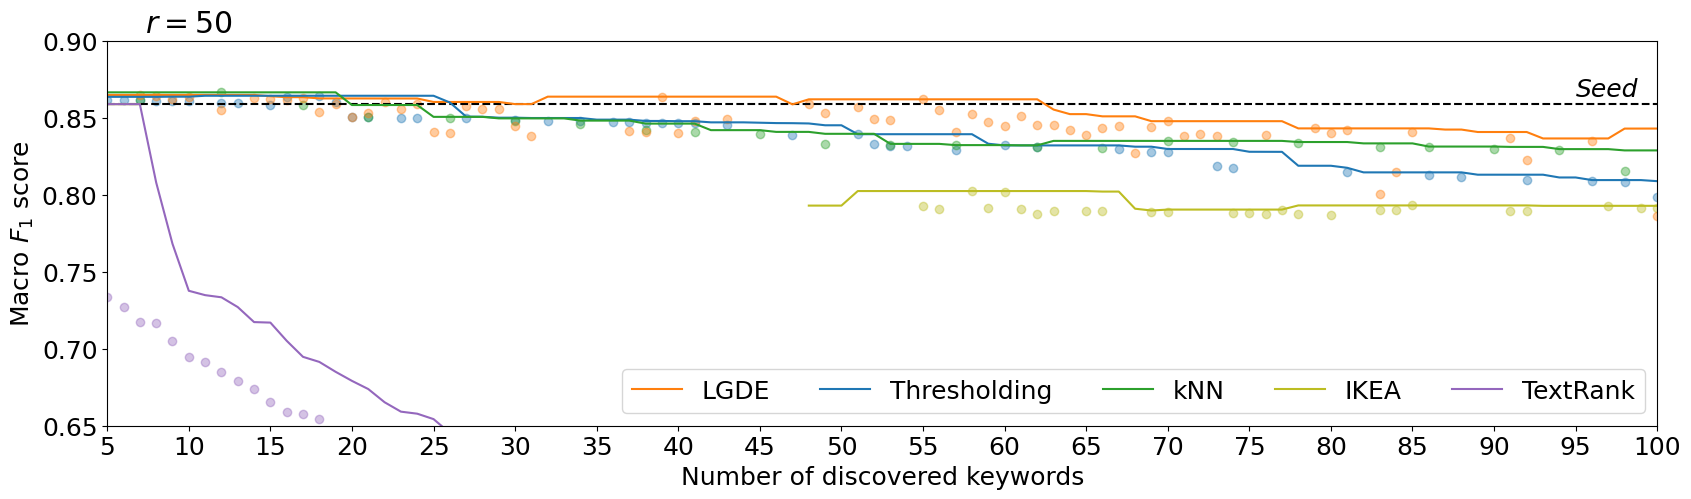

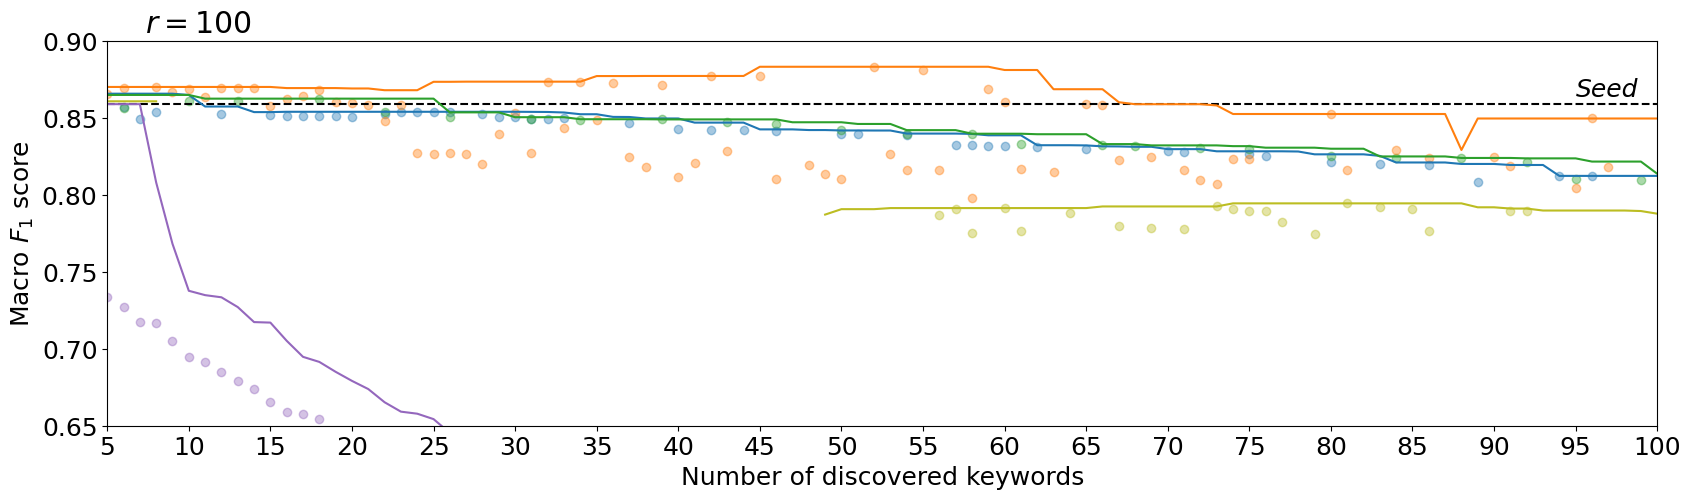

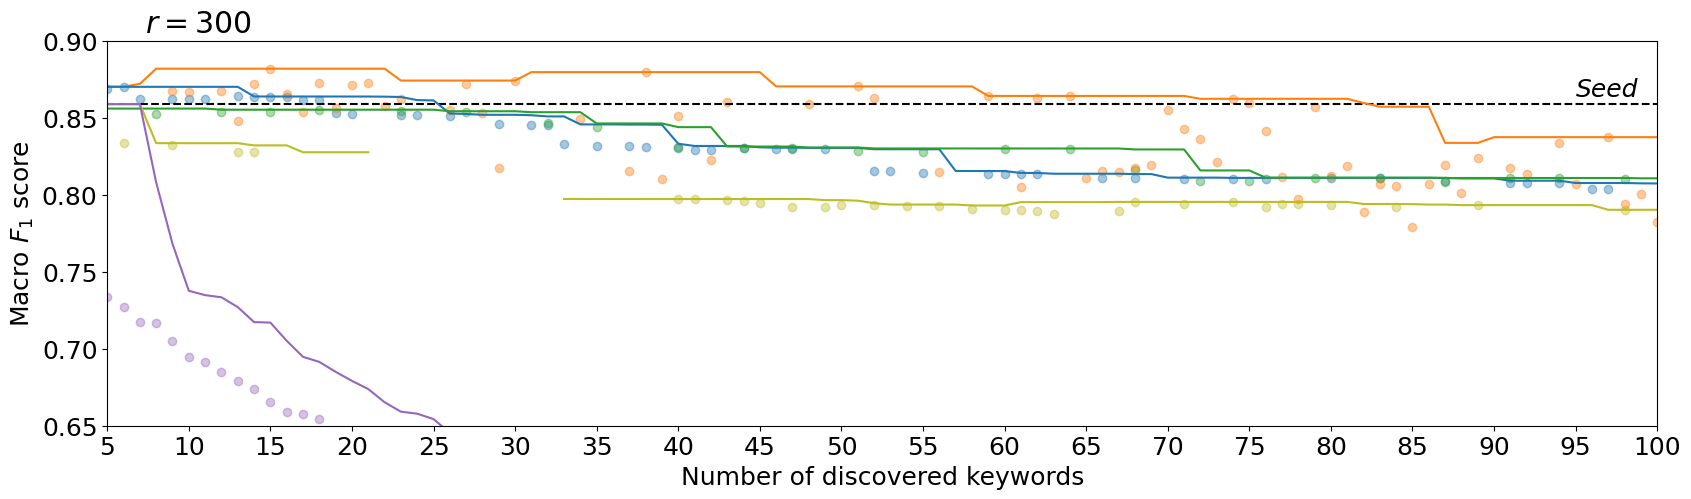

In [17]:
dimension_string = ["50","100","300"]

for j, results in enumerate([results_50d,results_100d,results_300d]):

    # unpack results for thresholding
    eps = results["th"]["eps"]
    fscore_th = results["th"]["fscore"]
    precision_th = results["th"]["precision"]
    recall_th = results["th"]["recall"]
    size_th = results["th"]["size"]

    # unpack results for kNN
    ks_knn = results["knn"]["ks"]
    fscore_knn = results["knn"]["fscore"]
    precision_knn = results["knn"]["precision"]
    recall_knn = results["knn"]["recall"]
    size_knn = results["knn"]["size"]

    # unpack results for IKEA
    eps_ikea = results["ikea"]["eps"]
    fscore_ikea = results["ikea"]["fscore"]
    precision_ikea = results["ikea"]["precision"]
    recall_ikea = results["ikea"]["recall"]
    size_ikea = results["ikea"]["size"]

    # unpack results for LGDE
    times = results["lgde"]["times"]
    ks = results["lgde"]["ks"]
    commmunities = results["lgde"]["communities"]
    fscore_lgde = results["lgde"]["fscore"]
    precision_lgde = results["lgde"]["precision"]
    recall_lgde = results["lgde"]["recall"]
    size_lgde = results["lgde"]["size"]

    ###################
    # comparison plot #
    ###################

    # keep only best F1 score per size for LGDE
    df_lgde_results = pd.DataFrame({"s":size_lgde.flatten(),"f1":fscore_lgde.flatten()})
    df_lgde_results = df_lgde_results.groupby(by="s").max()
    s_lgde = np.asarray(list(df_lgde_results.to_dict()["f1"].keys()),dtype=int)
    f_lgde = np.asarray(list(df_lgde_results.to_dict()["f1"].values()))

    # keep only best F1 score per size for thresholding
    df_th_results = pd.DataFrame({"s":size_th.flatten(),"f1":fscore_th.flatten()})
    df_th_results = df_th_results.groupby(by="s").max()
    s_th = np.asarray(list(df_th_results.to_dict()["f1"].keys()),dtype=int)
    f_th = np.asarray(list(df_th_results.to_dict()["f1"].values()))

    # keep only best F1 score per size for kNN
    df_knn_results = pd.DataFrame({"s":size_knn.flatten(),"f1":fscore_knn.flatten()})
    df_knn_results = df_knn_results.groupby(by="s").max()
    s_knn = np.asarray(list(df_knn_results.to_dict()["f1"].keys()),dtype=int)
    f_knn = np.asarray(list(df_knn_results.to_dict()["f1"].values()))

    # keep only best F1 score per size for ikea
    df_ikea_results = pd.DataFrame({"s":size_ikea.flatten(),"f1":fscore_ikea.flatten()})
    df_ikea_results = df_ikea_results.groupby(by="s").max()
    s_ikea = np.asarray(list(df_ikea_results.to_dict()["f1"].keys()),dtype=int)
    f_ikea = np.asarray(list(df_ikea_results.to_dict()["f1"].values()))

    # keep only best F1 score per size for TextRank
    df_tr_results = pd.DataFrame({"s":size_tr[ind_tr[0]].flatten(),"f1":fscore_tr[ind_tr[0]].flatten()})
    df_tr_results = df_tr_results.groupby(by="s").max()
    s_tr = np.asarray(list(df_tr_results.to_dict()["f1"].keys()),dtype=int)
    f_tr = np.asarray(list(df_tr_results.to_dict()["f1"].values()))

    # apply max pooling to LGDE
    block_size = 15
    f_lgde_max = []
    sizes = np.arange(1,int(s_lgde.max())+1)
    for i in range(len(sizes)):
        try:
            f_lgde_max.append(f_lgde[(sizes[i]-int(block_size/2)<=s_lgde) * (s_lgde<=sizes[i]+int(block_size/2))].max())
        except:
            f_lgde_max.append(np.nan)
    f_lgde_max = np.asarray(f_lgde_max)

    # apply max pooling to thresholding
    f_th_max = []
    for i in range(len(sizes)):
        f_th_max.append(f_th[(sizes[i]-int(block_size/2)<=s_th) * (s_th<=sizes[i]+int(block_size/2))].max())
    f_th_max = np.asarray(f_th_max)

    # apply max pooling to knn
    f_knn_max = []
    for i in range(len(sizes)):
        f_knn_max.append(f_knn[(sizes[i]-int(block_size/2)<=s_knn) * (s_knn<=sizes[i]+int(block_size/2))].max())
    f_knn_max = np.asarray(f_knn_max)

    # apply max pooling to ikea
    f_ikea_max = []
    for i in range(len(sizes)):
        f_ikea_block = f_ikea[(sizes[i]-int(block_size/2)<=s_ikea) * (s_ikea<=sizes[i]+int(block_size/2))]
        if len(f_ikea_block) > 0:
            f_ikea_max.append(f_ikea_block.max())
        else:
            f_ikea_max.append(np.nan)
    f_ikea_max = np.asarray(f_ikea_max)

    # apply max pooling to TextRank
    f_tr_max = []
    for i in range(len(sizes)):
        f_tr_block = f_tr[(sizes[i]-int(block_size/2)<=s_tr) * (s_tr<=sizes[i]+int(block_size/2))]
        if len(f_tr_block) > 0:
            f_tr_max.append(f_tr_block.max())
        else:
            f_tr_max.append(np.nan)
    f_tr_max = np.asarray(f_tr_max)

    # plot
    fig, ax = plt.subplots(1, figsize=(20, 5))

    # plot seed train score
    ax.axhline(y=0.859, c="black",ls="--")
    ax.annotate("Seed", xy = (95, 0.859 + 0.005), c="black", fontstyle='italic')

    # scatter plote train scores of different methods
    ax.scatter(s_th[s_th<=s_lgde.max()],f_th[s_th<=s_lgde.max()],alpha=0.4)
    ax.scatter(s_knn[s_knn<=s_lgde.max()],f_knn[s_knn<=s_lgde.max()],alpha=0.4, c="C2")
    ax.scatter(s_ikea[s_ikea<=s_lgde.max()],f_ikea[s_ikea<=s_lgde.max()],alpha=0.4, c="C8")
    ax.scatter(s_tr[s_tr<=s_lgde.max()],f_tr[s_tr<=s_lgde.max()],alpha=0.4, c="C4")
    ax.scatter(s_lgde,f_lgde, alpha=0.4, c="C1")

    # plot max pooled train scores
    ax.plot(sizes,f_lgde_max, c="C1",label="LGDE")
    ax.plot(sizes, f_th_max, c="C0",label="Thresholding")
    ax.plot(sizes,f_knn_max, c="C2",label="kNN")
    ax.plot(sizes,f_ikea_max, c="C8",label="IKEA")
    ax.plot(sizes,f_tr_max, c="C4",label="TextRank")

    # set labels etc.
    if j == 0:
            ax.legend(loc=4,ncol=5)
    ax.set(ylim=(0.65,0.9),xlim=(5,100),xticks=np.arange(5,101,5))
    plt.title(f"    $r=${dimension_string[j]}",loc="left")
    ax.set(xlabel="Number of discovered keywords", ylabel="Macro $F_1$ score")

    # store plots
    plt.savefig("figures/" +dimension_string[j]+'comparison-baselines.pdf', bbox_inches='tight')
    plt.show()

## 5) Detailed comparison for dimension $r=50$

In [18]:
# size constraints
min_size = 30
max_size = 50

In [19]:
##############
# GS results #
##############

# unpack results for thresholding
eps = results_50d["th"]["eps"]
fscore_th = results_50d["th"]["fscore"]
precision_th = results_50d["th"]["precision"]
recall_th = results_50d["th"]["recall"]
size_th = results_50d["th"]["size"]

# unpack results for kNN
ks_knn = results_50d["knn"]["ks"]
fscore_knn = results_50d["knn"]["fscore"]
precision_knn = results_50d["knn"]["precision"]
recall_knn = results_50d["knn"]["recall"]
size_knn = results_50d["knn"]["size"]

# unpack results_50d for IKEA
eps_ikea = results_50d["ikea"]["eps"]
fscore_ikea = results_50d["ikea"]["fscore"]
precision_ikea = results_50d["ikea"]["precision"]
recall_ikea = results_50d["ikea"]["recall"]
size_ikea = results_50d["ikea"]["size"]

# unpack results_50d for LGDE with LSWL
ks_lswl = results_50d["lswl"]["ks"]
fscore_lswl = results_50d["lswl"]["fscore"]
precision_lswl = results_50d["lswl"]["precision"]
recall_lswl = results_50d["lswl"]["recall"]
size_lswl = results_50d["lswl"]["size"]

# unpack results for LGDE
times = results_50d["lgde"]["times"]
ks = results_50d["lgde"]["ks"]
commmunities = results_50d["lgde"]["communities"]
fscore_lgde = results_50d["lgde"]["fscore"]
precision_lgde = results_50d["lgde"]["precision"]
recall_lgde = results_50d["lgde"]["recall"]
size_lgde = results_50d["lgde"]["size"]

# apply size constraints to thresholding
fscore_sc_th = fscore_th.copy()
fscore_sc_th[min_size > size_th] = np.nan
fscore_sc_th[size_th > max_size] = np.nan

# apply size constraints to kNN
fscore_sc_knn = fscore_knn.copy()
fscore_sc_knn[min_size > size_knn] = np.nan
fscore_sc_knn[size_knn > max_size] = np.nan

# apply size constraints to IKEA
fscore_sc_ikea = fscore_ikea.copy()
fscore_sc_ikea[min_size > size_ikea] = np.nan
fscore_sc_ikea[size_ikea > 60] = np.nan # exception for IKEA because of gap

# apply size constraints to LGDE with LSWL
fscore_sc_lswl = fscore_lswl.copy()
fscore_sc_lswl[10 > size_lswl] = np.nan # exception for LSWL because of gap
fscore_sc_lswl[size_lswl > max_size] = np.nan

# apply size constraints to lgde
fscore_sc_lgde = fscore_lgde.copy()
for ind_pair in np.argwhere(size_lgde < min_size):
    fscore_sc_lgde[ind_pair[0],ind_pair[1]] = np.nan
for ind_pair in np.argwhere(size_lgde > max_size):
    fscore_sc_lgde[ind_pair[0],ind_pair[1]] = np.nan

# compute best thresholding hyperparameter
ind_th = np.nanargmax(fscore_sc_th)
best_epsilon_50d = eps[ind_th]

# compute best knn hyperparameter
ind_knn = np.nanargmax(fscore_sc_knn)
best_k_50d_knn = ks_knn[ind_knn]

# compute best IKEA hyperparameter
ind_ikea = np.nanargmax(fscore_sc_ikea)
best_epsilon_50d_ikea = eps_ikea[ind_ikea]

# compute best lswl hyperparameter
ind_lswl = np.nanargmax(fscore_sc_lswl)
best_k_50d_lswl = ks_lswl[ind_lswl]

# compute best LGDE hyperparamers
ind_lgde = tuple(np.argwhere(fscore_sc_lgde == np.nanmax(fscore_sc_lgde))[0])
best_k_50d = ks[ind_lgde[0]]
best_t_50d = times[ind_lgde[1]]

### 5.1) Thresholding


### Thresholding ###

Best epsilon at $r=50$: 0.774


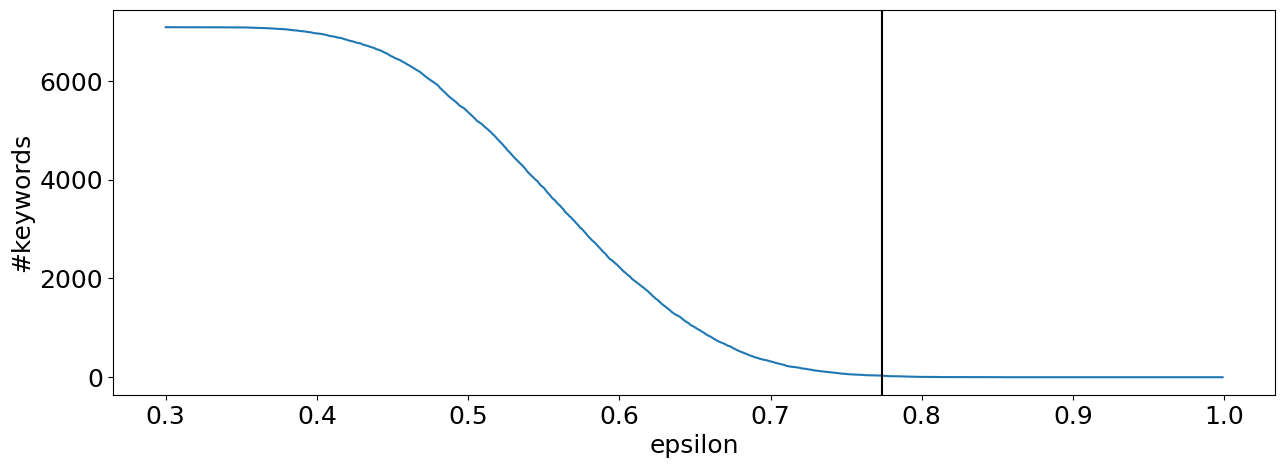

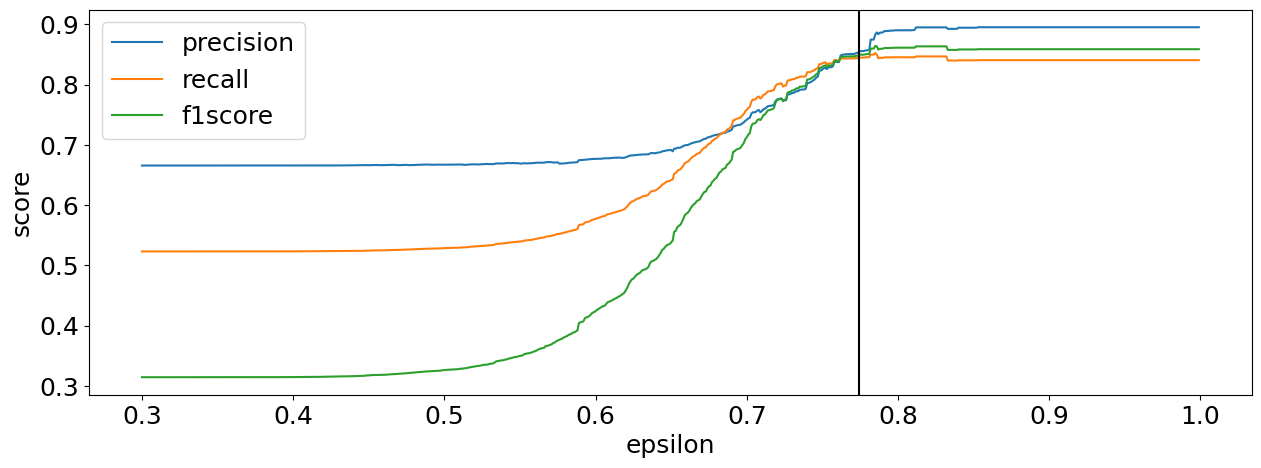

Number of discovered keywords at $r=50$: 30 

Epsilon balls:

nigger --> ['nigger', 'fuck', 'niggers', 'faggot', 'asshole', 'bitch', 'slur', 'weasel', 'nigga', 'spouting']
faggot --> ['paki', 'nigger', 'niggers', 'faggot', 'yikes', 'asshole', 'crybaby', 'bullshit', 'bitch', 'prob', 'ugh', 'scumbag', 'puke', 'aww']
retard --> ['retard', 'retards']
retarded --> ['retarded', 'mentally', 'insane', 'convicted', 'autistic', 'intellectually', 'sane', 'competent', 'olds', 'offenders', 'morally', 'cared', 'liking']
cunt --> ['cunt', 'asshole', 'bitch']

Discovered words: ['asshole', 'autistic', 'aww', 'bitch', 'bullshit', 'cared', 'competent', 'convicted', 'crybaby', 'fuck', 'insane', 'intellectually', 'liking', 'mentally', 'morally', 'nigga', 'niggers', 'offenders', 'olds', 'paki', 'prob', 'puke', 'retards', 'sane', 'scumbag', 'slur', 'spouting', 'ugh', 'weasel', 'yikes']

Train scores for thresholding expanded dictionary at $r=50$:

              precision    recall  f1-score   support

     

In [20]:
################
# Thresholding #
################

print("\n### Thresholding ###\n")

print("Best epsilon at $r=50$:",round(best_epsilon_50d,3))

# plot size
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(eps,size_th)
ax.axvline(x=best_epsilon_50d, c = 'black')
ax.set(xlabel="epsilon", ylabel="#keywords")
plt.show()

# plot F1
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(eps,precision_th,label="precision")
ax.plot(eps,recall_th,label="recall")
ax.plot(eps,fscore_th,label="f1score")
ax.axvline(x=best_epsilon_50d, c = 'black')
ax.set(xlabel="epsilon",ylabel="score")
ax.legend()
plt.show()

# expand with the optimal epsilon
thres_50d = Thresholding(seed_dict,word_list,word_vecs_50d)
thres_50d.expand(best_epsilon_50d)

print("Number of discovered keywords at $r=50$:", thres_50d.n_discovered,"\n")

print("Epsilon balls:\n")
for keyword in thres_50d.seed_dict[:15]:
    print(keyword,"-->",thres_50d.epsilon_balls_[keyword])

print("\nDiscovered words:", sorted(thres_50d.discovered_dict_))

print("\nTrain scores for thresholding expanded dictionary at $r=50$:\n")
_,_,_ =  evaluate_prediction(thres_50d.expanded_dict_, y_train, dt_train)

print("\nTest scores for thresholding expanded dictionary at $r=50$:\n")
_,_,_ = evaluate_prediction(thres_50d.expanded_dict_, y_test, dt_test)

In [21]:
# compute max similarity of tr**ny with seed keywords
max_sim = np.around(np.array([thres_50d.pairwise_word_similarity("tranny",kw) for kw in seed_dict]).max(),3)
# compute size of corresponding thresholding dict
thres_50d.expand(max_sim)
# get size of expanded dictionary
print(f"Epsilon {max_sim} and size {len(thres_50d.discovered_dict_)}.")
print("\nTest scores:\n")
_,_,_ = evaluate_prediction(thres_50d.expanded_dict_, y_test, dt_test)

Epsilon 0.719 and size 192.

Test scores:

              precision    recall  f1-score   support

       False      0.908     0.722     0.805      9057
        True      0.631     0.866     0.730      4968

    accuracy                          0.773     14025
   macro avg      0.770     0.794     0.767     14025
weighted avg      0.810     0.773     0.778     14025



### 5.2) kNN


### kNN ###

Best k at $r=50$: 7


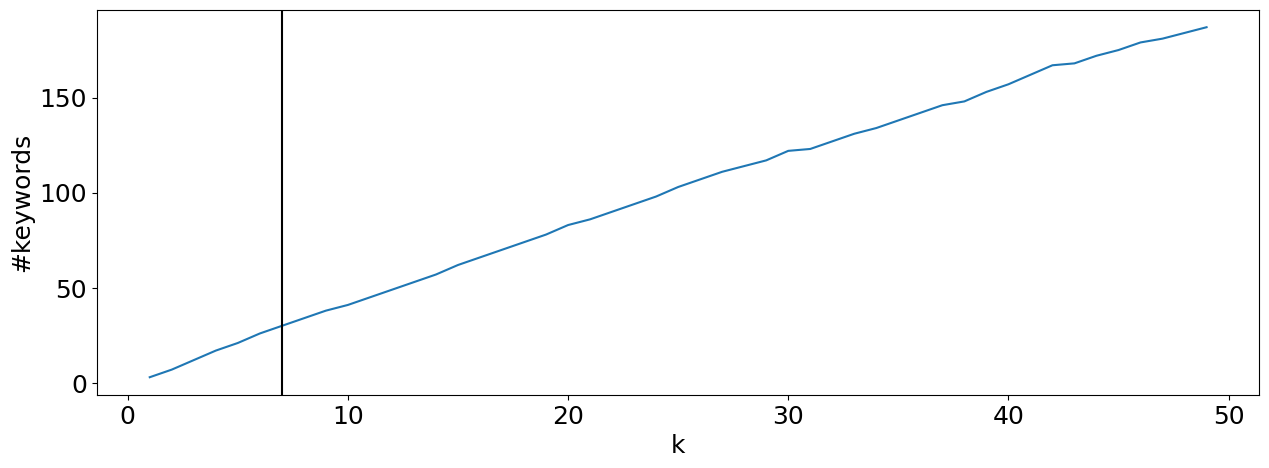

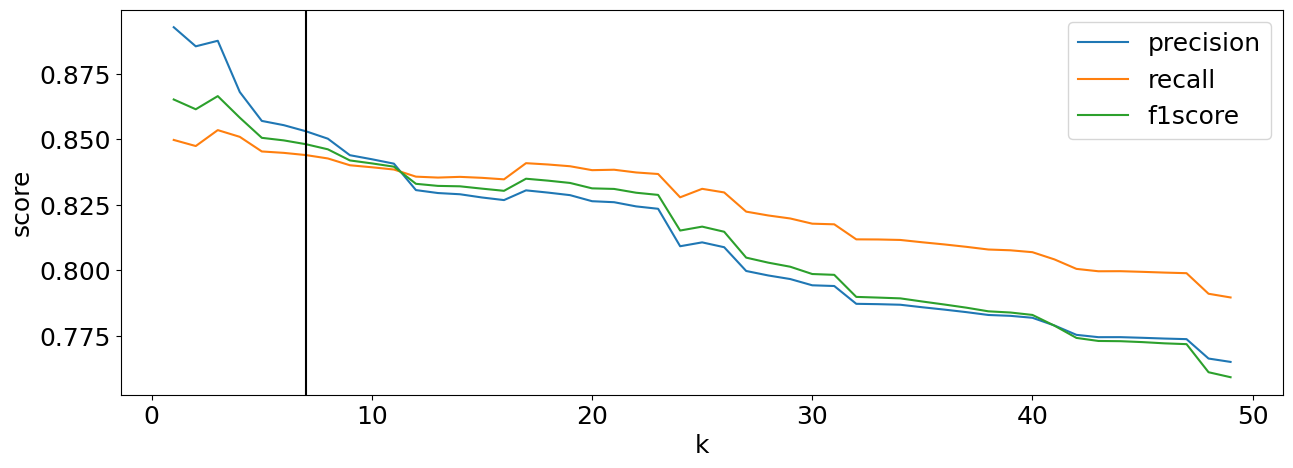

Number of discovered keywords at $r=50$: 30 

k-nearest neighbors:

nigger --> ['nigger', 'faggot', 'slur', 'niggers', 'fuck', 'asshole', 'weasel', 'nigga']
faggot --> ['faggot', 'nigger', 'asshole', 'ugh', 'prob', 'aww', 'scumbag', 'paki']
retard --> ['retard', 'retards', 'smarter', 'leftism', 'strive', 'fuckin', 'theyre', 'behave']
retarded --> ['retarded', 'cared', 'mentally', 'intellectually', 'offenders', 'morally', 'sane', 'insane']
cunt --> ['cunt', 'bitch', 'asshole', 'hag', 'fag', 'gg', 'nigga', 'yer']

Discovered words: ['asshole', 'aww', 'behave', 'bitch', 'cared', 'fag', 'fuck', 'fuckin', 'gg', 'hag', 'insane', 'intellectually', 'leftism', 'mentally', 'morally', 'nigga', 'niggers', 'offenders', 'paki', 'prob', 'retards', 'sane', 'scumbag', 'slur', 'smarter', 'strive', 'theyre', 'ugh', 'weasel', 'yer']

Train scores for kNN expanded dictionary at $r=50$:

              precision    recall  f1-score   support

       False      0.883     0.908     0.895     27169
        True

In [22]:
#######
# kNN #
#######

print("\n### kNN ###\n")

print("Best k at $r=50$:",round(best_k_50d_knn,3))

# plot size
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(ks_knn,size_knn)
ax.axvline(x=best_k_50d_knn, c = 'black')
ax.set(xlabel="k", ylabel="#keywords")
plt.show()

# plot F1
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(ks_knn,precision_knn,label="precision")
ax.plot(ks_knn,recall_knn,label="recall")
ax.plot(ks_knn,fscore_knn,label="f1score")
ax.axvline(x=best_k_50d_knn, c = 'black')
ax.set(xlabel="k",ylabel="score")
ax.legend()
plt.show()

# expand with the optimal k
knn_50d = KNearestNeighbors(seed_dict,word_list,word_vecs_50d)
knn_50d.expand(best_k_50d_knn)

print("Number of discovered keywords at $r=50$:", knn_50d.n_discovered,"\n")

print("k-nearest neighbors:\n")
for keyword in knn_50d.seed_dict[:15]:
    print(keyword,"-->",knn_50d.neighbors_[keyword])

print("\nDiscovered words:", sorted(knn_50d.discovered_dict_))

print("\nTrain scores for kNN expanded dictionary at $r=50$:\n")
_,_,_ =  evaluate_prediction(knn_50d.expanded_dict_, y_train, dt_train)

print("\nTest scores for kNN expanded dictionary at $r=50$:\n")
_,_,_ = evaluate_prediction(knn_50d.expanded_dict_, y_test, dt_test)

### 5.3) IKEA


### IKEA ###

Best epsilon at $r=50$: 0.701


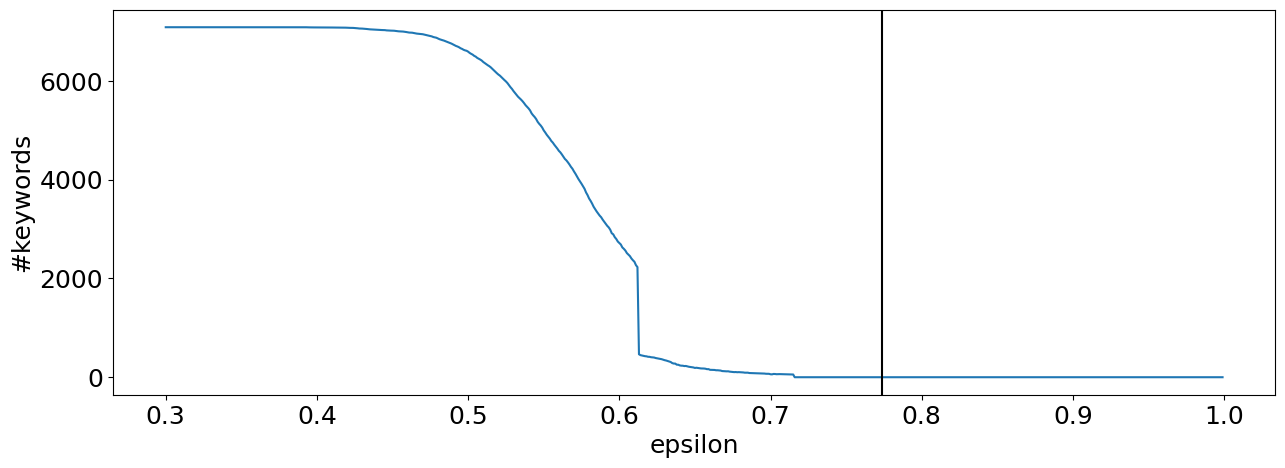

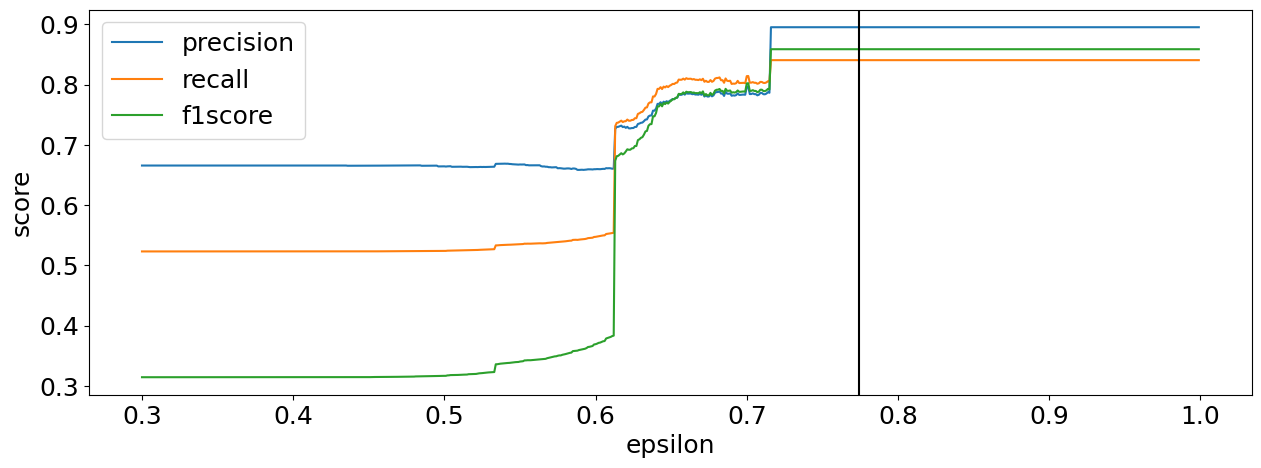

Number of discovered keywords at $r=50$: 58 


Discovered words: ['ahhh', 'ass', 'asshole', 'aww', 'awww', 'beaner', 'bitch', 'bullshit', 'commie', 'crap', 'crybaby', 'cunts', 'damn', 'damned', 'everytime', 'fools', 'freaking', 'fuck', 'fuckin', 'fucking', 'fucks', 'goddamn', 'gotta', 'hey', 'hmmm', 'hmmmm', 'idiot', 'idiotic', 'idiots', 'kidding', 'kinda', 'mommy', 'moronic', 'motherfucker', 'nigga', 'niggas', 'nope', 'oops', 'paki', 'prob', 'puke', 'shit', 'shite', 'simp', 'skank', 'sucks', 'thats', 'ugh', 'whats', 'whoa', 'whore', 'whos', 'woah', 'wow', 'yeah', 'yer', 'yikes', 'youre']

Train scores for IKEA expanded dictionary at $r=50$:

              precision    recall  f1-score   support

       False      0.890     0.810     0.848     27169
        True      0.703     0.818     0.756     14905

    accuracy                          0.813     42074
   macro avg      0.797     0.814     0.802     42074
weighted avg      0.824     0.813     0.816     42074


Test scores for IKEA 

In [23]:
########
# IKEA #
########

print("\n### IKEA ###\n")

print("Best epsilon at $r=50$:",round(best_epsilon_50d_ikea,3))

# plot size
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(eps,size_ikea)
ax.axvline(x=best_epsilon_50d, c = 'black')
ax.set(xlabel="epsilon", ylabel="#keywords")
plt.show()

# plot F1
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(eps,precision_ikea,label="precision")
ax.plot(eps,recall_ikea,label="recall")
ax.plot(eps,fscore_ikea,label="f1score")
ax.axvline(x=best_epsilon_50d, c = 'black')
ax.set(xlabel="epsilon",ylabel="score")
ax.legend()
plt.show()

# expand with the optimal epsilon
ikea_50d = IKEA(seed_dict,word_list,word_vecs_50d)
ikea_50d.expand(best_epsilon_50d_ikea)

print("Number of discovered keywords at $r=50$:", ikea_50d.n_discovered,"\n")

print("\nDiscovered words:", sorted(ikea_50d.discovered_dict_))

print("\nTrain scores for IKEA expanded dictionary at $r=50$:\n")
_,_,_ =  evaluate_prediction(ikea_50d.expanded_dict_, y_train, dt_train)

print("\nTest scores for IKEA expanded dictionary at $r=50$:\n")
_,_,_ = evaluate_prediction(ikea_50d.expanded_dict_, y_test, dt_test)

### 5.4) Other local community detection methods


### LSWL / SIWO ###

Best k at $r=50$: 4


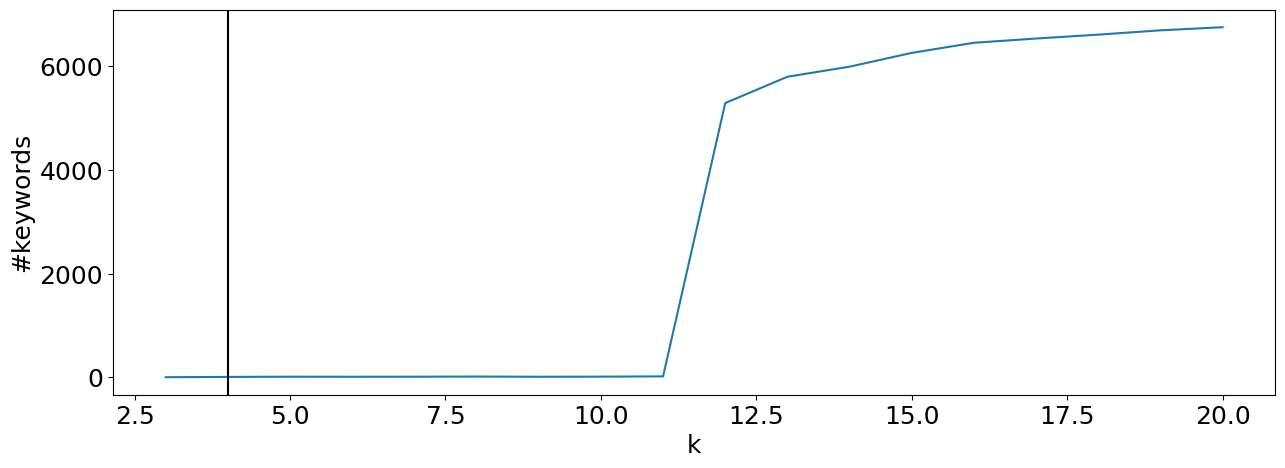

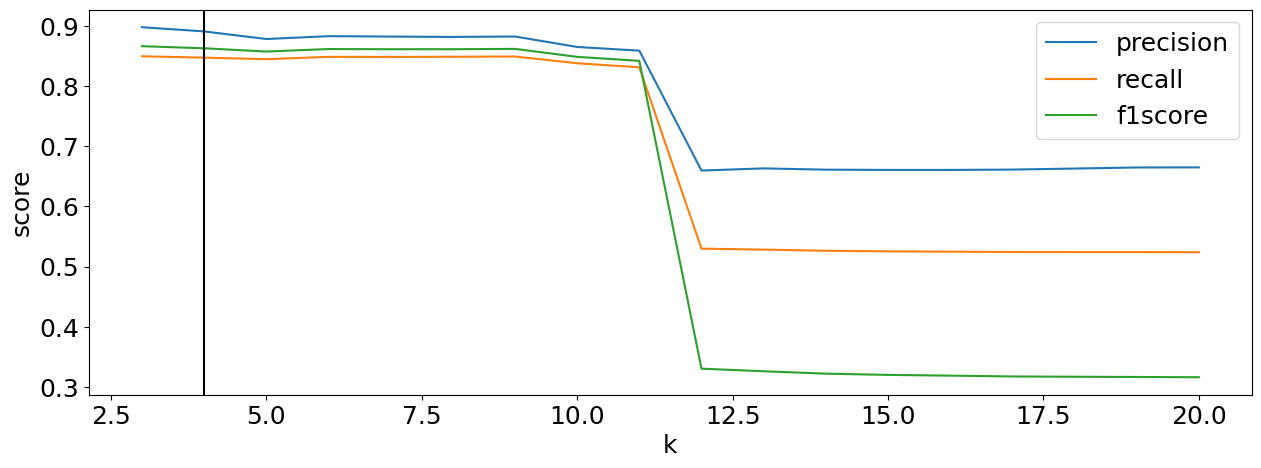

100%|██████████| 5/5 [00:00<00:00, 297.32it/s]

Number of discovered keywords at $r=50$: 11 

Semantic communities:

nigger --> ['nigger', 'faggot']
faggot --> ['faggot', 'prob']
retard --> ['retard', 'retards', 'regressive']
retarded --> ['retarded', 'emotionally', 'physically', 'mentally', 'sane', 'competent']
cunt --> ['snowflake', 'cunt', 'fag', 'hag']

Discovered words: ['competent', 'emotionally', 'fag', 'hag', 'mentally', 'physically', 'prob', 'regressive', 'retards', 'sane', 'snowflake']

Train scores for LSWL expanded dictionary at $r=50$:

              precision    recall  f1-score   support

       False      0.867     0.962     0.912     27169
        True      0.914     0.732     0.813     14905

    accuracy                          0.881     42074
   macro avg      0.891     0.847     0.863     42074
weighted avg      0.884     0.881     0.877     42074


Test scores for LSWL expanded dictionary at $r=50$:

              precision    recall  f1-score   support

       False      0.865     0.960     0.910      9057
  

In [24]:
########
# LSWL #
########

print("\n### LSWL / SIWO ###\n")

print("Best k at $r=50$:",round(best_k_50d_lswl,3))

# plot size
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(ks_lswl,size_lswl)
ax.axvline(x=best_k_50d_lswl, c = 'black')
ax.set(xlabel="k", ylabel="#keywords")
plt.show()

# plot F1
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(ks_lswl,precision_lswl,label="precision")
ax.plot(ks_lswl,recall_lswl,label="recall")
ax.plot(ks_lswl,fscore_lswl,label="f1score")
ax.axvline(x=best_k_50d_lswl, c = 'black')
ax.set(xlabel="k",ylabel="score")
ax.legend()
plt.show()

# expand with the optimal k
lswl_50d = LGDEWithCDlib(seed_dict,word_list,word_vecs_50d)
lswl_50d.expand(best_k_50d_lswl, method="lswl")

print("Number of discovered keywords at $r=50$:", lswl_50d.n_discovered,"\n")

print("Semantic communities:\n")
for keyword in lswl_50d.seed_dict[:15]:
    print(keyword,"-->",lswl_50d.semantic_communities_[keyword])

print("\nDiscovered words:", sorted(lswl_50d.discovered_dict_))

print("\nTrain scores for LSWL expanded dictionary at $r=50$:\n")
_,_,_ =  evaluate_prediction(lswl_50d.expanded_dict_, y_train, dt_train)

print("\nTest scores for LSWL expanded dictionary at $r=50$:\n")
_,_,_ = evaluate_prediction(lswl_50d.expanded_dict_, y_test, dt_test)

In [25]:
#########
# Mod R #
#########

# unpack dictionary
modr_size = results_localmod_50d["modr"]["size"]
modr_fscore_train = results_localmod_50d["modr"]["fscore_train"]
modr_fscore_test = results_localmod_50d["modr"]["fscore_test"]
modr_ks = results_localmod_50d["modr"]["ks"]

# apply size constraints
modr_fscore_train_sc = []
modr_fscore_test_sc = []

for i in range(len(modr_ks)):
    # comput size constraint indices per k
    sc_ind = (modr_size[i] <= max_size) * (modr_size[i] >= min_size)
    modr_fscore_train_sc.append(modr_fscore_train[i][sc_ind])
    modr_fscore_test_sc.append(modr_fscore_test[i][sc_ind])

# find best k based on mean train F1 scores of admissible dictionaries
modr_fscore_train_sc_mean = np.array([np.array(scores_k).mean() if len(scores_k) > 0 else np.nan for scores_k in modr_fscore_train_sc])
modr_best_k_ind = np.nanargmax(modr_fscore_train_sc_mean) # best k only has 19 admissible dictionaries, we choose second-best below
modr_best_k_ind = np.argsort(-modr_fscore_train_sc_mean)[1]
modr_best_k = modr_ks[modr_best_k_ind]
print("Best k for 'modr':",modr_best_k)
print("Number of admissible dictionaries:", len(modr_fscore_train_sc[modr_best_k_ind]))

# compute 95% CIs for train and test F1 scores
modr_fscore_train_m, modr_fscore_train_l, modr_fscore_train_r = mean_confidence_interval(modr_fscore_train_sc[modr_best_k_ind])
print(f"Average train F1 score for 'modr': {modr_fscore_train_m} ({modr_fscore_train_l}--{modr_fscore_train_r})")
modr_fscore_test_m, modr_fscore_test_l, modr_fscore_test_r = mean_confidence_interval(modr_fscore_test_sc[modr_best_k_ind],digits=4)
print(f"Average test F1 score for 'modr': {modr_fscore_test_m} ({modr_fscore_test_l}--{modr_fscore_test_r})")

#########
# Mod M #
#########

# unpack dictionary
modm_size = results_localmod_50d["modm"]["size"]
modm_fscore_train = results_localmod_50d["modm"]["fscore_train"]
modm_fscore_test = results_localmod_50d["modm"]["fscore_test"]
modm_ks = results_localmod_50d["modm"]["ks"]

# apply size constraints
modm_fscore_train_sc = []
modm_fscore_test_sc = []

for i in range(len(modm_ks)):
    # comput size constraint indices per k
    sc_ind = (modm_size[i] <= max_size) * (modm_size[i] >= min_size)
    modm_fscore_train_sc.append(modm_fscore_train[i][sc_ind])
    modm_fscore_test_sc.append(modm_fscore_test[i][sc_ind])

# find best k based on mean train F1 scores of admissible dictionaries
modm_fscore_train_sc_mean = np.array([np.array(scores_k).mean() if len(scores_k) > 0 else np.nan for scores_k in modm_fscore_train_sc])
modm_best_k_ind = np.nanargmax(modm_fscore_train_sc_mean) # best k only has 19 admissible dictionaries, we choose second-best below
modm_best_k_ind = np.argsort(-modm_fscore_train_sc_mean)[1]
modm_best_k = modm_ks[modm_best_k_ind]
print("\nBest k for 'modm':",modm_best_k)
print("Number of admissible dictionaries:", len(modm_fscore_train_sc[modm_best_k_ind]))

# compute 95% CIs for train and test F1 scores
modm_fscore_train_m, modm_fscore_train_l, modm_fscore_train_r = mean_confidence_interval(modm_fscore_train_sc[modm_best_k_ind])
print(f"Average train F1 score for 'modm': {modm_fscore_train_m} ({modm_fscore_train_l}--{modm_fscore_train_r})")
modm_fscore_test_m, modm_fscore_test_l, modm_fscore_test_r = mean_confidence_interval(modm_fscore_test_sc[modm_best_k_ind])
print(f"Average test F1 score for 'modm': {modm_fscore_test_m} ({modm_fscore_test_l}--{modm_fscore_test_r})")

Best k for 'modr': 11
Number of admissible dictionaries: 25
Average train F1 score for 'modr': 0.83 (0.83--0.83)
Average test F1 score for 'modr': 0.8272 (0.827--0.8275)

Best k for 'modm': 10
Number of admissible dictionaries: 25
Average train F1 score for 'modm': 0.834 (0.832--0.835)
Average test F1 score for 'modm': 0.835 (0.833--0.836)


### 5.5) LGDE


### LGDE ###

Best hyperparameters at $r=50$:k=13, t=2


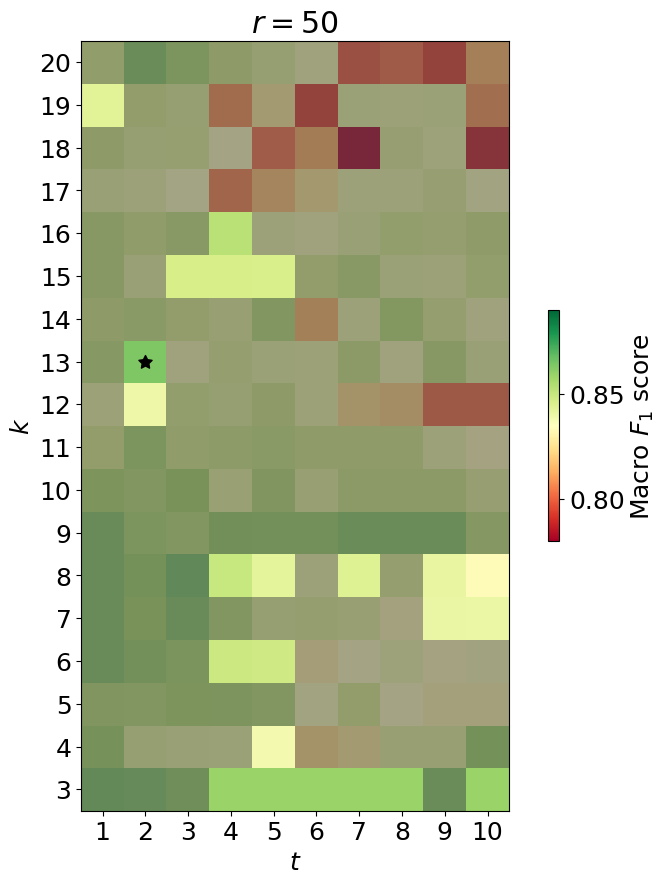

100%|██████████| 5/5 [00:41<00:00,  8.29s/it]


Number of discovered keywords: 39 

Semantic communities:

nigger --> ['nigger', 'liar', 'altright', 'weasel', 'faggot', 'scumbag', 'asshole', 'niggers', 'nigga', 'spouting', 'baiting', 'slur']
faggot --> ['faggot', 'commie', 'scumbag', 'simp', 'aww', 'crybaby', 'prob', 'beaner', 'hater', 'tranny', 'cunts', 'moron', 'pedo', 'wetback', 'braindead', 'limey', 'brainless', 'awww', 'btw', 'faggots', 'goyim', 'woah', 'commies', 'skank', 'fag', 'sluts']
retard --> ['retard']
retarded --> ['retarded']
cunt --> ['cunt', 'hag', 'fag', 'gg', 'snowflake', 'tl', 'fucker']

Discovered words: ['altright', 'asshole', 'aww', 'awww', 'baiting', 'beaner', 'braindead', 'brainless', 'btw', 'commie', 'commies', 'crybaby', 'cunts', 'fag', 'faggots', 'fucker', 'gg', 'goyim', 'hag', 'hater', 'liar', 'limey', 'moron', 'nigga', 'niggers', 'pedo', 'prob', 'scumbag', 'simp', 'skank', 'slur', 'sluts', 'snowflake', 'spouting', 'tl', 'tranny', 'weasel', 'wetback', 'woah']

Train scores for LGDE expanded dictionary a

In [26]:
########
# LGDE #
########

print("\n### LGDE ###\n")
print(f"Best hyperparameters at $r=50$:k={best_k_50d}, t={best_t_50d}")

# plot F1 score
fig, ax = plt.subplots(1, figsize=(10, 10))
im = ax.imshow(np.ones_like(fscore_lgde),cmap='Greys',origin='lower',alpha=0.7, vmin=0,vmax=1)
im = ax.imshow(fscore_lgde,cmap='RdYlGn',origin='lower',alpha=0.5,vmin=0.78,vmax=0.89)
im = ax.imshow(fscore_sc_lgde,cmap='RdYlGn',origin='lower',vmin=0.78,vmax=0.89)
ax.set(xlabel="$t$", ylabel="$k$", xticks=np.arange(len(times)),yticks=np.arange(len(ks)), xticklabels=times, yticklabels=ks)
ax.scatter(ind_lgde[1],ind_lgde[0],color='black',marker=(5, 1),s=100)
plt.colorbar(im,shrink=0.3,label="Macro $F_1$ score")
plt.title('$r=50$')
plt.savefig('figures/lgde_f1score-50d.pdf', bbox_inches='tight')
plt.show()

# expand with the optimal k and t
lgde_50d = LGDE(seed_dict,word_list,word_vecs_50d)
lgde_50d.expand(k=best_k_50d, t=best_t_50d)

print("\nNumber of discovered keywords:", lgde_50d.n_discovered,"\n")
print("Semantic communities:\n")
for keyword in lgde_50d.seed_dict[:10]:
    print(keyword,"-->",lgde_50d.semantic_communities_[keyword])

print("\nDiscovered words:", sorted(lgde_50d.discovered_dict_))

print("\nTrain scores for LGDE expanded dictionary at $r=50$:\n")
_,_,_ = evaluate_prediction(lgde_50d.expanded_dict_, y_train, dt_train)

print("\nTest scores for LGDE expanded dictionary at $r=50$:\n")
_,_,_ = evaluate_prediction(lgde_50d.expanded_dict_, y_test, dt_test)

In [27]:
print("### LGDE 50d ###\n")
error_analysis(lgde_50d, likelihood_ratio_positive)

### LGDE 50d ###

ERROR ANALYSIS DISCOVERED KWs:


LR       Seed (sim)
altright   0.737830  nigger (0.742) 
gg         0.163173    cunt (0.757) 
hater      0.781232   faggot (0.76) 
slur       0.470419  nigger (0.791) 
snowflake  0.957010    cunt (0.682) 
tl         0.716130    cunt (0.612) 
woah       0.221471  faggot (0.705)

ERROR ANALYSIS SEED KWs:


Seed LR  # community  LR <= 1 (in %)     Min LR  Median LR  \
nigger    82.188888           12           16.67   0.470419   1.599356   
faggot    78.966956           26            7.69   0.221471   3.211733   
retard    18.069710            1            0.00  18.069710  18.069710   
retarded  15.096898            1            0.00  15.096898  15.096898   
cunt      15.922463            7           42.86   0.163173   2.369738   

            Mean LR     Max LR  # Inf LR  
nigger    20.910023  82.188888         0  
faggot    10.885880  78.966956         0  
retard    18.069710  18.069710         0  
retarded  15.096898  15.096898         0  
cunt       8.474333  33.723192         0

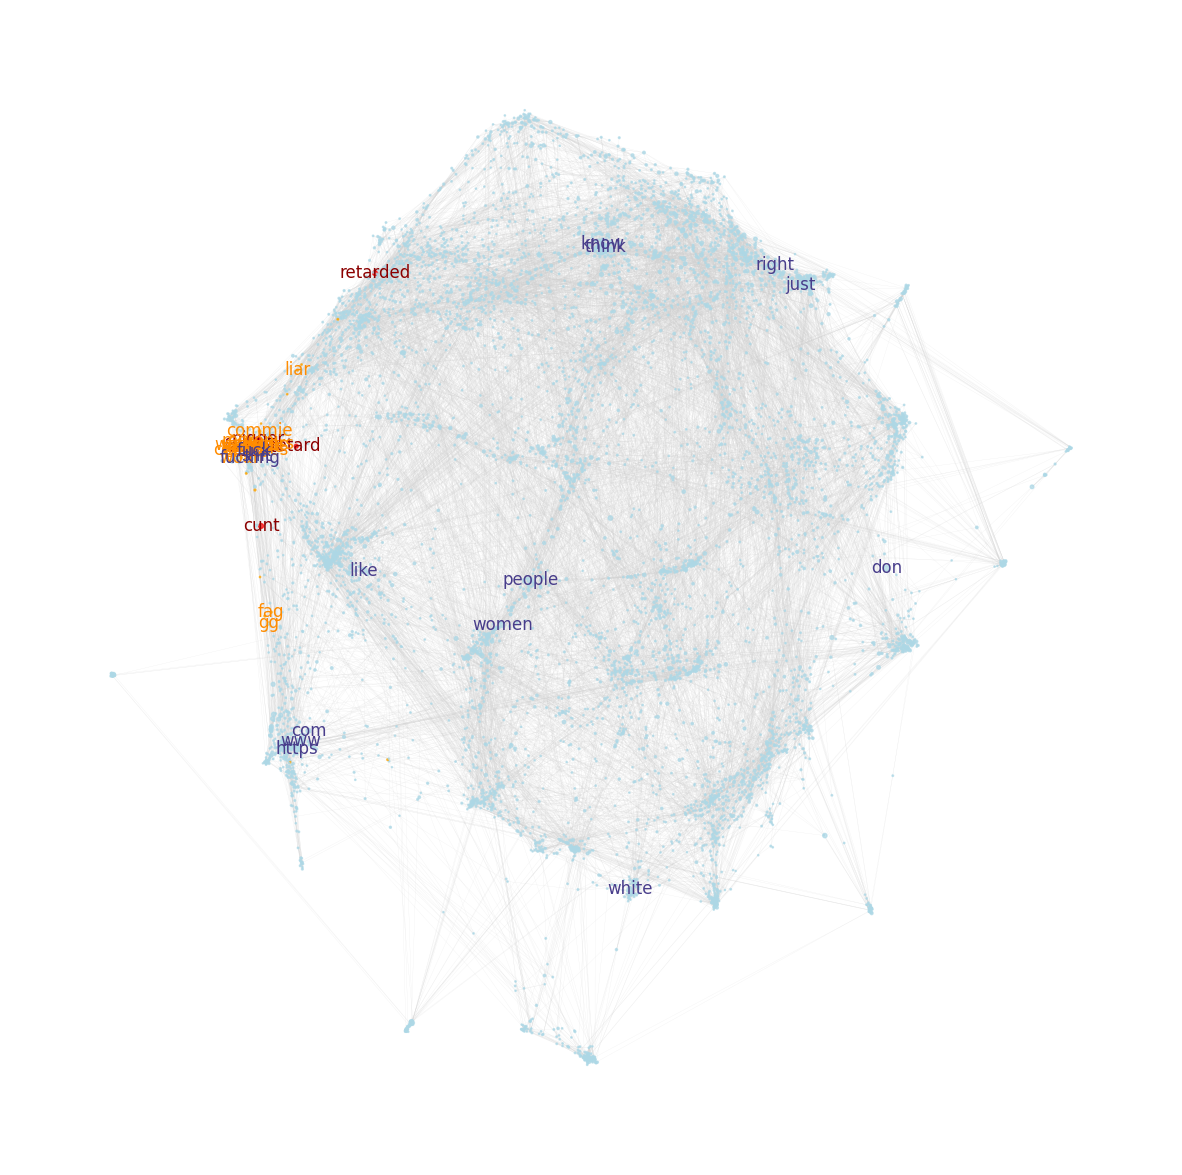

In [28]:
# visualise semantic network
lgde_50d.construct_nx_graph()
fig = lgde_50d.plot_semantic_network(n_top=15,doc_freq=list(doc_freq),lcc_only=True,node_size_factor=0.2,alpha=0.7,edge_width=0.1,plot_with_other_words=True)
fig.savefig("figures/redgab_semantic_network_50d.pdf",dpi=fig.dpi,bbox_inches="tight")

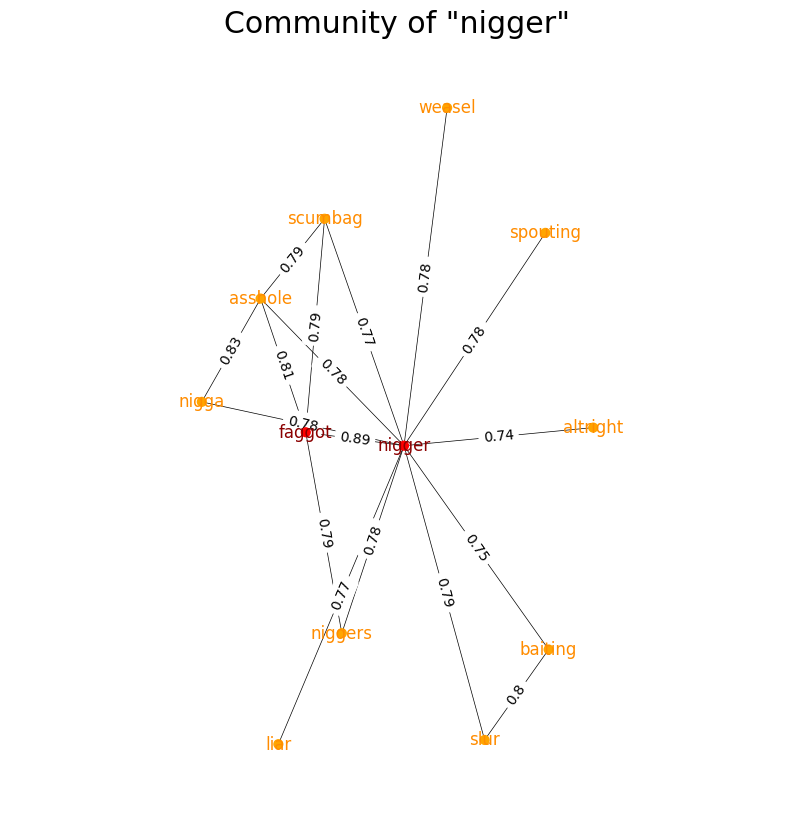

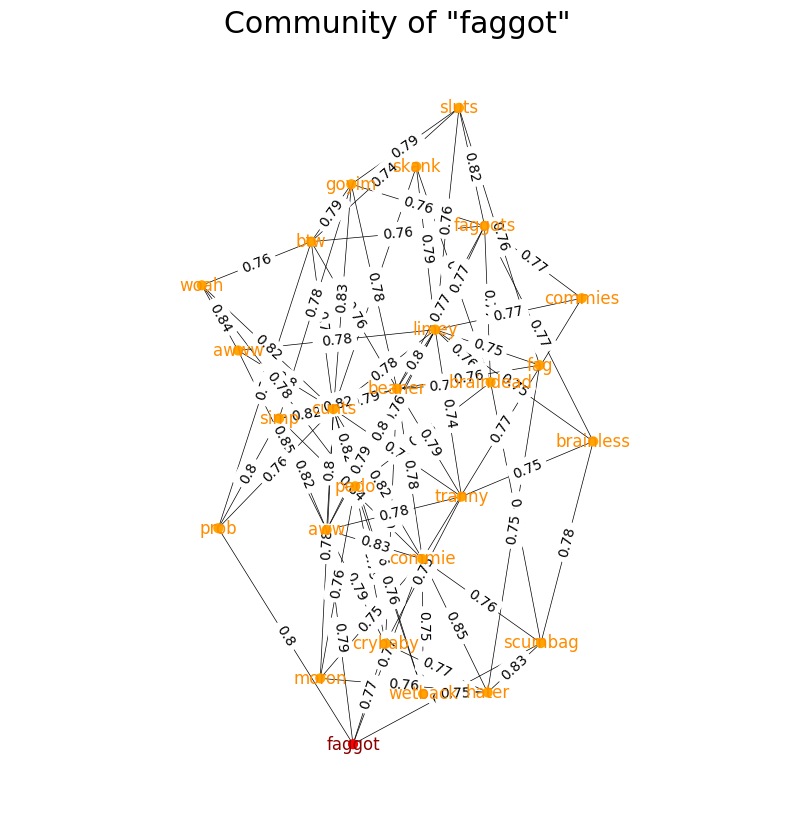

The keyword 'retard' is a singleton semantic community.
The keyword 'retarded' is a singleton semantic community.


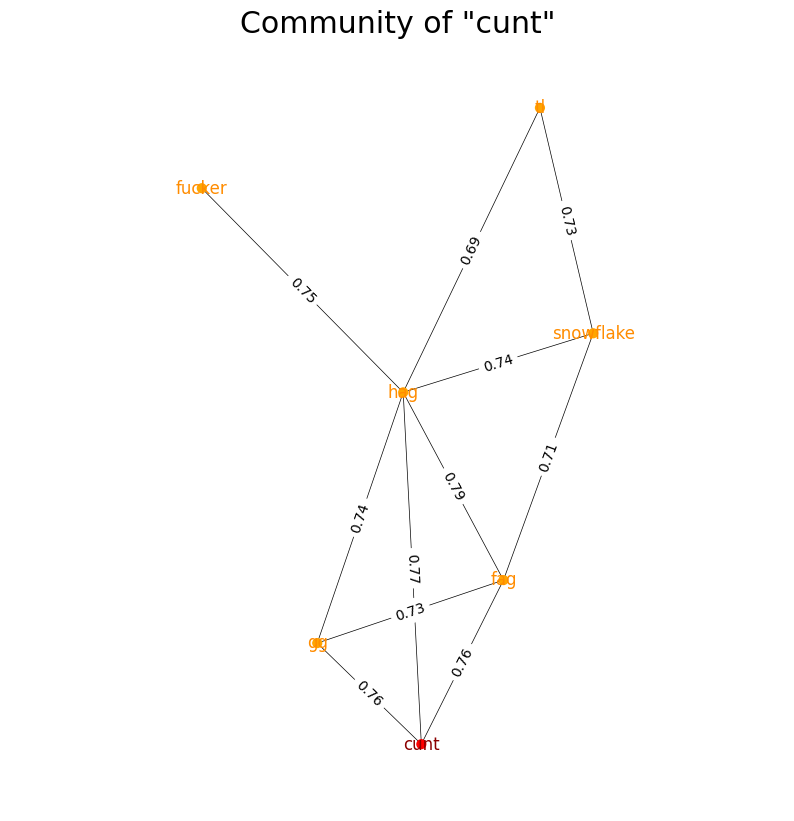

In [29]:
# plot semantic communities
lgde_50d.plot_semantic_communities(n_plots=5,figsize=(10,10),path="figures/50d-")

### 5.6) Significance tests

In [33]:
# get thresholding of same size as LGDE
eps_samesize = eps[np.argmin(size_th>len(lgde_50d.discovered_dict_))]
thres_50d_prime = Thresholding(seed_dict,word_list,word_vecs_50d)
thres_50d_prime.expand(eps_samesize)

# evaluate thresholding on test data
print("\nTest scores for same size thresholding expanded dictionary at $r=50$:\n")
_,_,_ = evaluate_prediction(thres_50d_prime.expanded_dict_, y_test, dt_test)

# determine which words are only found by LGDE or thresholding
lgde_only_50 =  list(set(lgde_50d.discovered_dict_) -  set(thres_50d_prime.discovered_dict_))
thres_only_50_prime = list(set(thres_50d_prime.discovered_dict_) - set(lgde_50d.discovered_dict_))

print("\nCOMPARISON BETWEEN BEST LGDE AND BEST THRESHOLDING OF SAME SIZE")

print("\nMedian LR+ Thresholding:", round(np.median(likelihood_ratio_positive[thres_only_50_prime]),2))
print("Median LR+ LGDE:", round(np.median(likelihood_ratio_positive[lgde_only_50]),2))
U, p = mannwhitneyu(likelihood_ratio_positive[lgde_only_50],likelihood_ratio_positive[thres_only_50_prime],alternative='greater',method='exact')
print('Mann-Whitney U test with alternative "greater": p =', np.around(p,5))

# free up memory
del thres_50d_prime
del thres_only_50_prime


Test scores for same size thresholding expanded dictionary at $r=50$:

              precision    recall  f1-score   support

       False      0.883     0.910     0.896      9057
        True      0.826     0.780     0.803      4968

    accuracy                          0.864     14025
   macro avg      0.855     0.845     0.849     14025
weighted avg      0.863     0.864     0.863     14025


COMPARISON BETWEEN BEST LGDE AND BEST THRESHOLDING OF SAME SIZE

Median LR+ Thresholding: 1.45
Median LR+ LGDE: 2.25
Mann-Whitney U test with alternative "greater": p = 0.02888


In [34]:
#######
# kNN #
#######

# get kNN of same size as LGDE
ks_knn_samesize = ks_knn[np.argmin(np.abs(size_knn - len(lgde_50d.discovered_dict_)))]
knn_50d_prime = KNearestNeighbors(seed_dict,word_list,word_vecs_50d)
knn_50d_prime.expand(ks_knn_samesize)

# determine which words are only found by LGDE or kNN
lgde_only_50 =  list(set(lgde_50d.discovered_dict_) -  set(knn_50d_prime.discovered_dict_))
knn_only_50d_prime = list(set(knn_50d_prime.discovered_dict_) - set(lgde_50d.discovered_dict_))

print("\nCOMPARISON BETWEEN BEST LGDE AND BEST kNN OF SAME SIZE")

print("\nMedian LR+ kNN:", round(np.median(likelihood_ratio_positive[knn_only_50d_prime]),2))
print("Median LR+ LGDE:", round(np.median(likelihood_ratio_positive[lgde_only_50]),2))
U, p = mannwhitneyu(likelihood_ratio_positive[lgde_only_50],likelihood_ratio_positive[knn_only_50d_prime],alternative='greater',method='exact')
print('Mann-Whitney U test with alternative "greater": p =', np.around(p,5))

# free up memory
del knn_50d_prime

########
# IKEA #
########

# get IKEA of same size as LGDE
eps_ikea_samesize = eps_ikea[np.argmin(np.abs(size_ikea - len(lgde_50d.discovered_dict_)))] 
ikea_50d_prime = IKEA(seed_dict,word_list,word_vecs_50d)
ikea_50d_prime.expand(eps_ikea_samesize)

# determine which words are only found by LGDE or IKEA
lgde_only_50 =  list(set(lgde_50d.discovered_dict_) -  set(ikea_50d_prime.discovered_dict_))
ikea_only_50d_prime = list(set(ikea_50d_prime.discovered_dict_) - set(lgde_50d.discovered_dict_))

print("\nCOMPARISON BETWEEN BEST LGDE AND BEST IKEA OF SAME SIZE")

print("\nMedian LR+ IKEA:", round(np.median(likelihood_ratio_positive[ikea_only_50d_prime]),2))
print("Median LR+ LGDE:", round(np.median(likelihood_ratio_positive[lgde_only_50]),2))
U, p = mannwhitneyu(likelihood_ratio_positive[lgde_only_50],likelihood_ratio_positive[ikea_only_50d_prime],alternative='greater',method='exact')
print('Mann-Whitney U test with alternative "greater": p =', np.around(p,5))

# free up memory
del ikea_50d_prime




COMPARISON BETWEEN BEST LGDE AND BEST kNN OF SAME SIZE

Median LR+ kNN: 1.91
Median LR+ LGDE: 2.23
Mann-Whitney U test with alternative "greater": p = 0.09632

COMPARISON BETWEEN BEST LGDE AND BEST IKEA OF SAME SIZE

Median LR+ IKEA: 1.41
Median LR+ LGDE: 2.28
Mann-Whitney U test with alternative "greater": p = 0.01076


In [35]:
############
# TextRank #
############

# get TextRank of same size as LGDE
ind_tr_samesize = np.argmin(np.abs(size_tr[ind_tr[0]] - len(lgde_50d.discovered_dict_)))
tr_50d_prime = discovered_dicts_tr[ind_tr[0]][ind_tr_samesize]

# determine which words are only found by LGDE or TextRank
lgde_only_50 =  list(set(lgde_50d.discovered_dict_) -  set(tr_50d_prime))
tr_only_50d_prime = list(set(tr_50d_prime) - set(lgde_50d.discovered_dict_))

print("\nCOMPARISON BETWEEN BEST LGDE AND BEST TextRank OF SAME SIZE")

print("\nMedian LR+ TextRank:", round(np.median(likelihood_ratio_positive[tr_only_50d_prime]),2))
print("Median LR+ LGDE:", round(np.median(likelihood_ratio_positive[lgde_only_50]),2))
U, p = mannwhitneyu(likelihood_ratio_positive[lgde_only_50],likelihood_ratio_positive[tr_only_50d_prime],alternative='greater',method='exact')
print('Mann-Whitney U test with alternative "greater": p =', np.around(p,7))


COMPARISON BETWEEN BEST LGDE AND BEST TextRank OF SAME SIZE

Median LR+ TextRank: 1.0
Median LR+ LGDE: 2.28
Mann-Whitney U test with alternative "greater": p = 5.7e-05


## 6) Detailed comparison for dimension $r=100$

In [36]:
##############
# GS results #
##############

# unpack results for thresholding
eps = results_100d["th"]["eps"]
fscore_th = results_100d["th"]["fscore"]
precision_th = results_100d["th"]["precision"]
recall_th = results_100d["th"]["recall"]
size_th = results_100d["th"]["size"]

# unpack results for kNN
ks_knn = results_100d["knn"]["ks"]
fscore_knn = results_100d["knn"]["fscore"]
precision_knn = results_100d["knn"]["precision"]
recall_knn = results_100d["knn"]["recall"]
size_knn = results_100d["knn"]["size"]

# unpack results_100d for IKEA
eps_ikea = results_100d["ikea"]["eps"]
fscore_ikea = results_100d["ikea"]["fscore"]
precision_ikea = results_100d["ikea"]["precision"]
recall_ikea = results_100d["ikea"]["recall"]
size_ikea = results_100d["ikea"]["size"]

# unpack results_100d for LGDE with LSWL
ks_lswl = results_100d["lswl"]["ks"]
fscore_lswl = results_100d["lswl"]["fscore"]
precision_lswl = results_100d["lswl"]["precision"]
recall_lswl = results_100d["lswl"]["recall"]
size_lswl = results_100d["lswl"]["size"]

# unpack results for LGDE
times = results_100d["lgde"]["times"]
ks = results_100d["lgde"]["ks"]
commmunities = results_100d["lgde"]["communities"]
fscore_lgde = results_100d["lgde"]["fscore"]
precision_lgde = results_100d["lgde"]["precision"]
recall_lgde = results_100d["lgde"]["recall"]
size_lgde = results_100d["lgde"]["size"]

# apply size constraints to thresholding
fscore_sc_th = fscore_th.copy()
fscore_sc_th[min_size > size_th] = np.nan
fscore_sc_th[size_th > max_size] = np.nan

# apply size constraints to kNN
fscore_sc_knn = fscore_knn.copy()
fscore_sc_knn[min_size > size_knn] = np.nan
fscore_sc_knn[size_knn > max_size] = np.nan

# apply size constraints to IKEA
fscore_sc_ikea = fscore_ikea.copy()
fscore_sc_ikea[min_size > size_ikea] = np.nan
fscore_sc_ikea[size_ikea > 60] = np.nan # exception for IKEA because of gap

# apply size constraints to LGDE with LSWL
fscore_sc_lswl = fscore_lswl.copy()
fscore_sc_lswl[min_size > size_lswl] = np.nan
fscore_sc_lswl[size_lswl > max_size] = np.nan

# apply size constraints to lgde
fscore_sc_lgde = fscore_lgde.copy()
for ind_pair in np.argwhere(size_lgde < min_size):
    fscore_sc_lgde[ind_pair[0],ind_pair[1]] = np.nan
for ind_pair in np.argwhere(size_lgde > max_size):
    fscore_sc_lgde[ind_pair[0],ind_pair[1]] = np.nan

# compute best thresholding hyperparameter
ind_th = np.nanargmax(fscore_sc_th)
best_epsilon_100d = eps[ind_th]

# compute best knn hyperparameter
ind_knn = np.nanargmax(fscore_sc_knn)
best_k_100d_knn = ks_knn[ind_knn]

# compute best IKEA hyperparameter
ind_ikea = np.nanargmax(fscore_sc_ikea)
best_epsilon_100d_ikea = eps_ikea[ind_ikea]

# compute best lswl hyperparameter
ind_lswl = np.nanargmax(fscore_sc_lswl)
best_k_100d_lswl = ks_lswl[ind_lswl]

# compute best LGDE hyperparamers
ind_lgde = tuple(np.argwhere(fscore_sc_lgde == np.nanmax(fscore_sc_lgde))[0])
best_k_100d = ks[ind_lgde[0]]
best_t_100d = times[ind_lgde[1]]

### 6.1) Thresholding


### Thresholding ###

Best epsilon at $r=100$: 0.681


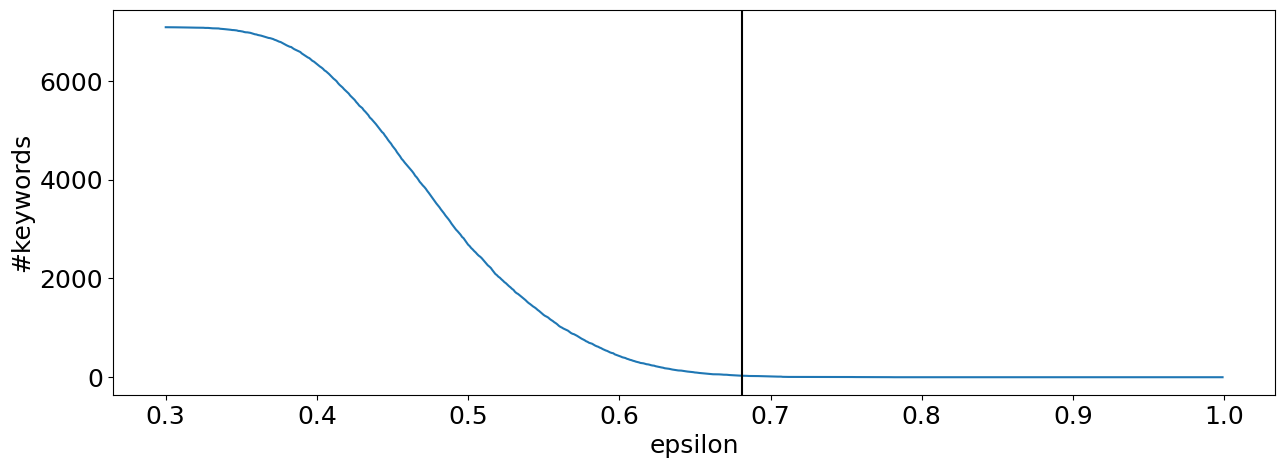

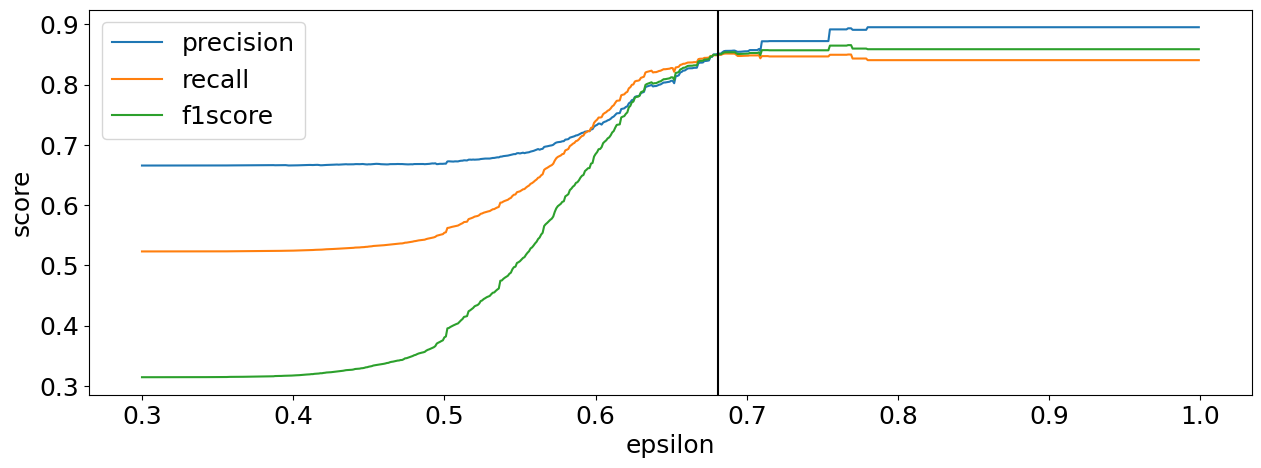

Number of discovered keywords at $r=100$: 30 

Epsilon balls:

nigger --> ['nigger', 'niggers', 'cunt', 'faggot', 'bitch', 'slur', 'weasel']
faggot --> ['nigger', 'niggers', 'cunt', 'faggot', 'crybaby', 'commie', 'bitch', 'fag']
retard --> ['retard', 'retards']
retarded --> ['honest', 'retarded', 'murderers', 'mentally', 'autistic', 'intellectually', 'incompetent', 'competent', 'offenders', 'morally', 'cared', 'engineers']
cunt --> ['nigger', 'fucking', 'fuck', 'cunt', 'faggot', 'asshole', 'bitch', 'whore', 'wetback', 'fag', 'hillbilly', 'turd', 'fuckin', 'shite', 'nigga', 'braindead']

Discovered words: ['asshole', 'autistic', 'bitch', 'braindead', 'cared', 'commie', 'competent', 'crybaby', 'engineers', 'fag', 'fuck', 'fuckin', 'fucking', 'hillbilly', 'honest', 'incompetent', 'intellectually', 'mentally', 'morally', 'murderers', 'nigga', 'niggers', 'offenders', 'retards', 'shite', 'slur', 'turd', 'weasel', 'wetback', 'whore']

Train scores for thresholding expanded dictionary at $r=50

In [37]:
################
# Thresholding #
################

print("\n### Thresholding ###\n")

print("Best epsilon at $r=100$:",round(best_epsilon_100d,3))

# plot size
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(eps,size_th)
ax.axvline(x=best_epsilon_100d, c = 'black')
ax.set(xlabel="epsilon", ylabel="#keywords")
plt.show()

# plot F1
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(eps,precision_th,label="precision")
ax.plot(eps,recall_th,label="recall")
ax.plot(eps,fscore_th,label="f1score")
ax.axvline(x=best_epsilon_100d, c = 'black')
ax.set(xlabel="epsilon",ylabel="score")
ax.legend()
plt.show()

# expand with the optimal epsilon
thres_100d = Thresholding(seed_dict,word_list,word_vecs_100d)
thres_100d.expand(best_epsilon_100d)

print("Number of discovered keywords at $r=100$:", thres_100d.n_discovered,"\n")

print("Epsilon balls:\n")
for keyword in thres_100d.seed_dict[:15]:
    print(keyword,"-->",thres_100d.epsilon_balls_[keyword])

print("\nDiscovered words:", sorted(thres_100d.discovered_dict_))

print("\nTrain scores for thresholding expanded dictionary at $r=50$:\n")
_,_,_ =  evaluate_prediction(thres_100d.expanded_dict_, y_train, dt_train)

print("\nTest scores for thresholding expanded dictionary at $r=50$:\n")
_,_,_ = evaluate_prediction(thres_100d.expanded_dict_, y_test, dt_test)

### 6.3) kNN


### kNN ###

Best k at $r=100$: 8


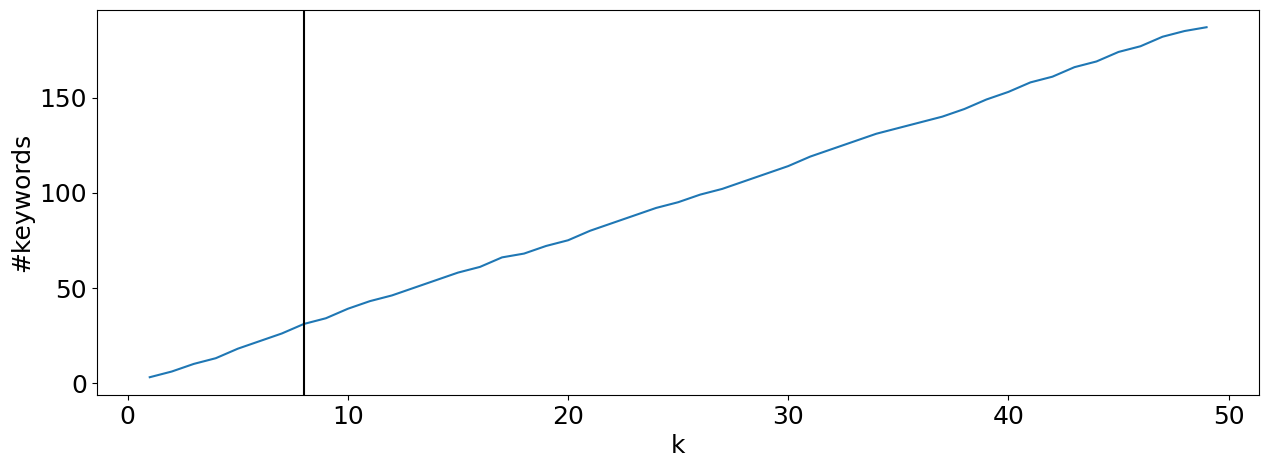

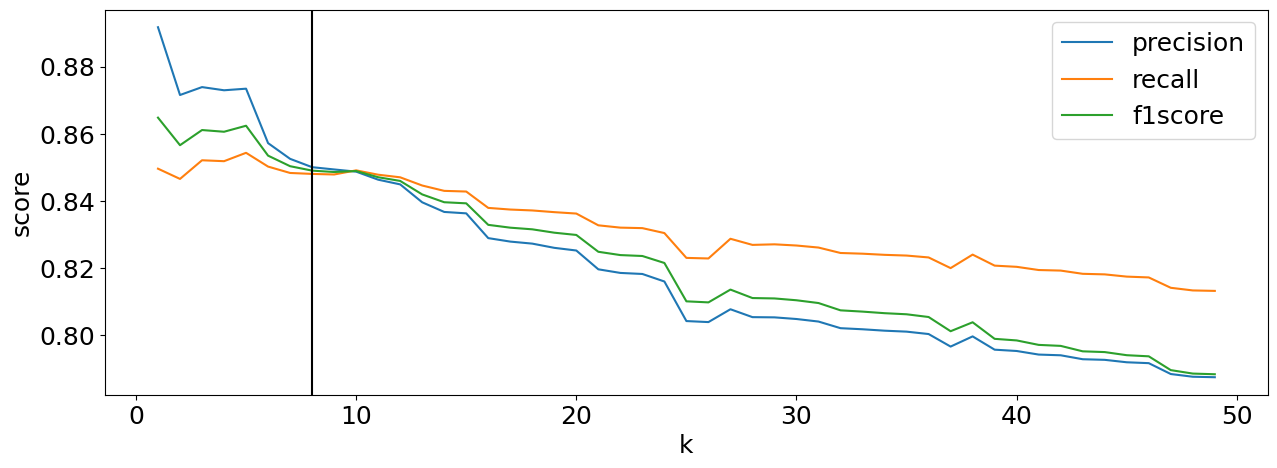

Number of discovered keywords at $r=100$: 31 

k-nearest neighbors:

nigger --> ['nigger', 'faggot', 'cunt', 'niggers', 'slur', 'weasel', 'bitch', 'idiot', 'phrase']
faggot --> ['faggot', 'nigger', 'cunt', 'crybaby', 'niggers', 'fag', 'commie', 'bitch', 'scum']
retard --> ['retard', 'retards', 'betas', 'bleed', 'moronic', 'niggas', 'starve', 'assimilate', 'theyre']
retarded --> ['retarded', 'mentally', 'offenders', 'morally', 'intellectually', 'incompetent', 'engineers', 'competent', 'autistic']
cunt --> ['cunt', 'bitch', 'fucking', 'faggot', 'nigger', 'whore', 'fuck', 'fuckin', 'hillbilly']

Discovered words: ['assimilate', 'autistic', 'betas', 'bitch', 'bleed', 'commie', 'competent', 'crybaby', 'engineers', 'fag', 'fuck', 'fuckin', 'fucking', 'hillbilly', 'idiot', 'incompetent', 'intellectually', 'mentally', 'morally', 'moronic', 'niggas', 'niggers', 'offenders', 'phrase', 'retards', 'scum', 'slur', 'starve', 'theyre', 'weasel', 'whore']

Train scores for kNN expanded dictionary at $

In [38]:
#######
# kNN #
#######

print("\n### kNN ###\n")

print("Best k at $r=100$:",round(best_k_100d_knn,3))

# plot size
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(ks_knn,size_knn)
ax.axvline(x=best_k_100d_knn, c = 'black')
ax.set(xlabel="k", ylabel="#keywords")
plt.show()

# plot F1
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(ks_knn,precision_knn,label="precision")
ax.plot(ks_knn,recall_knn,label="recall")
ax.plot(ks_knn,fscore_knn,label="f1score")
ax.axvline(x=best_k_100d_knn, c = 'black')
ax.set(xlabel="k",ylabel="score")
ax.legend()
plt.show()

# expand with the optimal k
knn_100d = KNearestNeighbors(seed_dict,word_list,word_vecs_100d)
knn_100d.expand(best_k_100d_knn)

print("Number of discovered keywords at $r=100$:", knn_100d.n_discovered,"\n")

print("k-nearest neighbors:\n")
for keyword in knn_100d.seed_dict[:15]:
    print(keyword,"-->",knn_100d.neighbors_[keyword])

print("\nDiscovered words:", sorted(knn_100d.discovered_dict_))

print("\nTrain scores for kNN expanded dictionary at $r=50$:\n")
_,_,_ =  evaluate_prediction(knn_100d.expanded_dict_, y_train, dt_train)

print("\nTest scores for kNN expanded dictionary at $r=50$:\n")
_,_,_ = evaluate_prediction(knn_100d.expanded_dict_, y_test, dt_test)

### 6.3) IKEA


### IKEA ###

Best epsilon at $r=100$: 0.61


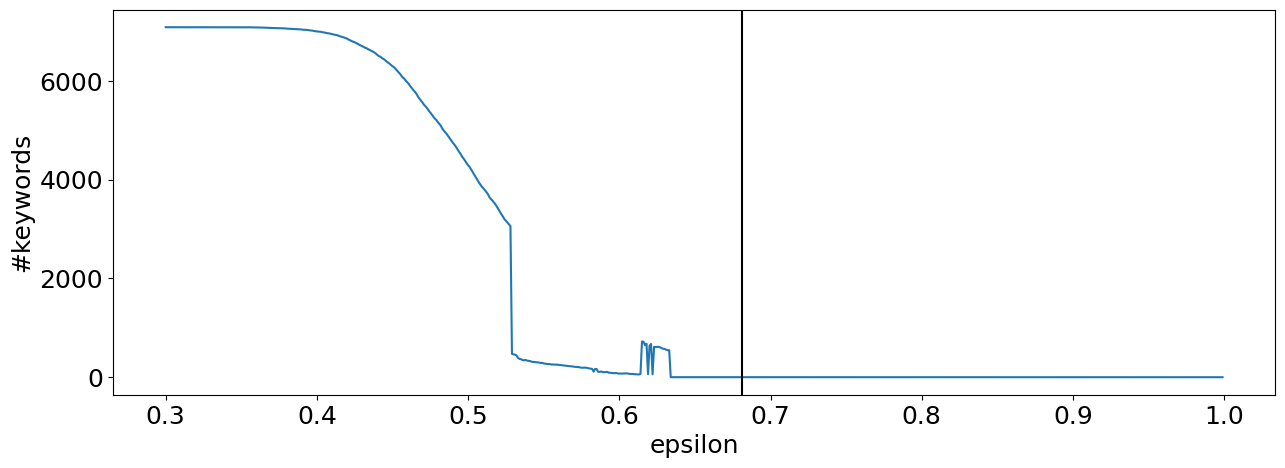

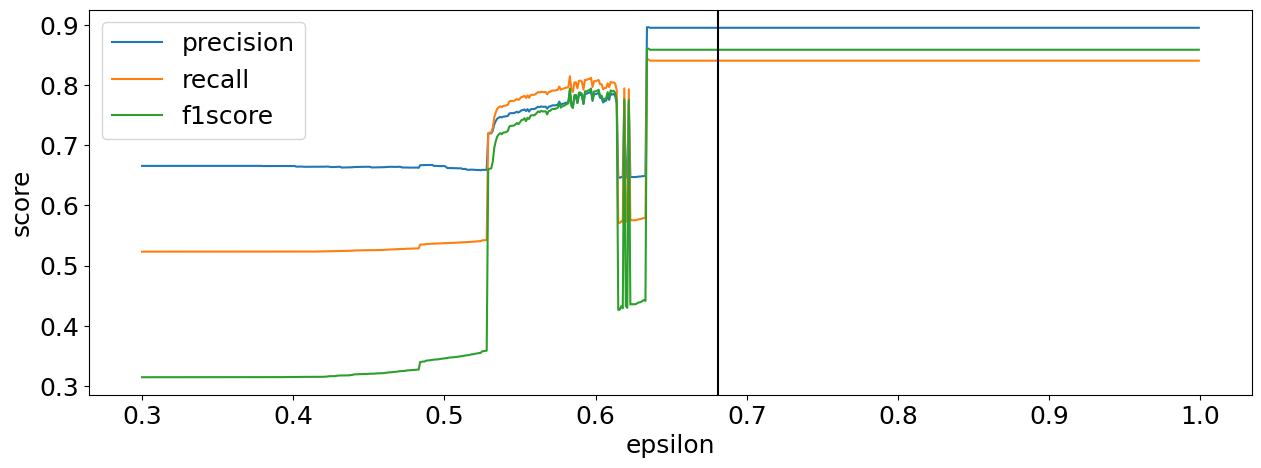

Number of discovered keywords at $r=100$: 60 


Discovered words: ['ahhh', 'asinine', 'ass', 'asshole', 'aww', 'awww', 'bastard', 'bitch', 'bullshit', 'crap', 'crybaby', 'damn', 'damned', 'dont', 'dumb', 'dunno', 'everytime', 'fag', 'foolish', 'freaking', 'fuck', 'fuckin', 'fucking', 'goddamn', 'gonna', 'gotcha', 'gotta', 'heck', 'hey', 'hmmm', 'hmmmm', 'idiot', 'idiotic', 'idiots', 'kidding', 'kinda', 'messed', 'mommy', 'moronic', 'motherfucker', 'nigga', 'niggas', 'nope', 'oops', 'pathetic', 'pretentious', 'puke', 'shit', 'shite', 'soooo', 'stupid', 'sucks', 'thats', 'ugh', 'whoa', 'whore', 'whos', 'wow', 'yeah', 'yikes']

Train scores for IKEA expanded dictionary at $r=50$:

              precision    recall  f1-score   support

       False      0.888     0.793     0.838     27169
        True      0.684     0.817     0.745     14905

    accuracy                          0.802     42074
   macro avg      0.786     0.805     0.791     42074
weighted avg      0.816     0.802     0.8

In [39]:
########
# IKEA #
########

print("\n### IKEA ###\n")

print("Best epsilon at $r=100$:",round(best_epsilon_100d_ikea,3))

# plot size
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(eps,size_ikea)
ax.axvline(x=best_epsilon_100d, c = 'black')
ax.set(xlabel="epsilon", ylabel="#keywords")
plt.show()

# plot F1
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(eps,precision_ikea,label="precision")
ax.plot(eps,recall_ikea,label="recall")
ax.plot(eps,fscore_ikea,label="f1score")
ax.axvline(x=best_epsilon_100d, c = 'black')
ax.set(xlabel="epsilon",ylabel="score")
ax.legend()
plt.show()

# expand with the optimal epsilon
ikea_100d = IKEA(seed_dict,word_list,word_vecs_100d)
ikea_100d.expand(best_epsilon_100d_ikea)

print("Number of discovered keywords at $r=100$:", ikea_100d.n_discovered,"\n")

print("\nDiscovered words:", sorted(ikea_100d.discovered_dict_))

print("\nTrain scores for IKEA expanded dictionary at $r=50$:\n")
_,_,_ =  evaluate_prediction(ikea_100d.expanded_dict_, y_train, dt_train)

print("\nTest scores for IKEA expanded dictionary at $r=50$:\n")
_,_,_ = evaluate_prediction(ikea_100d.expanded_dict_, y_test, dt_test)

### 6.4) Other local community detection methods


### LSWL / SIWO ###

Best k at $r=100$: 10


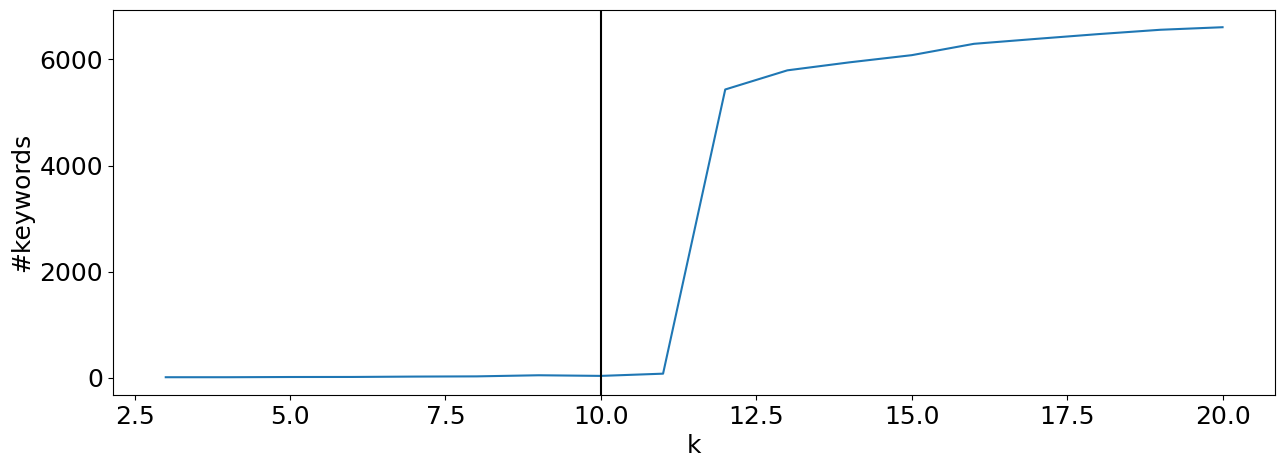

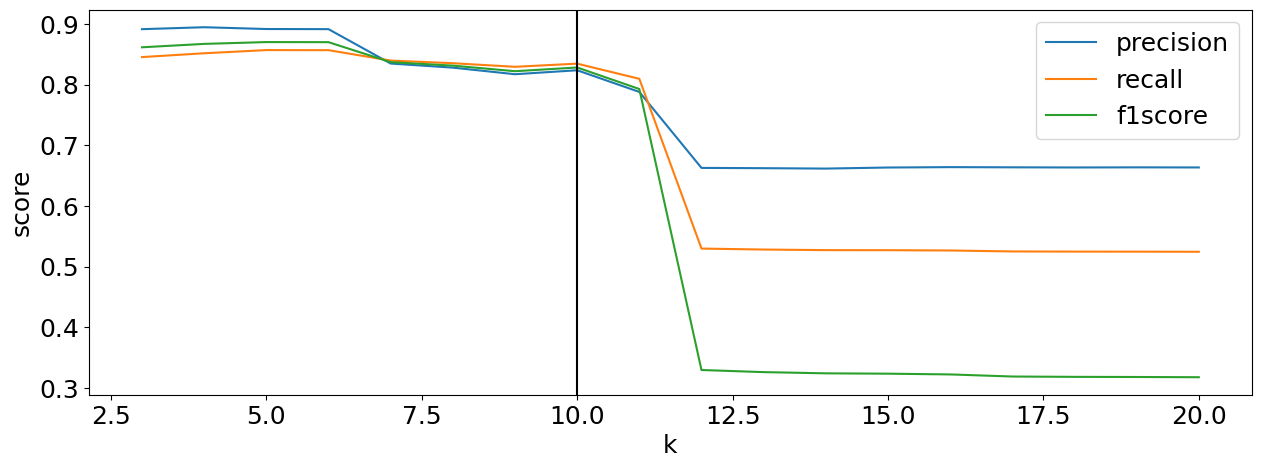

100%|██████████| 5/5 [00:00<00:00, 247.50it/s]

Number of discovered keywords at $r=100$: 33 

Semantic communities:

nigger --> ['nigger', 'walkaway', 'niggers', 'faggot']
faggot --> ['nigger', 'walkaway', 'niggers', 'faggot']
retard --> ['retard', 'retards', 'perversion', 'maggot']
retarded --> ['retarded', 'mentally', 'empowered', 'incompetent', 'competent']
cunt --> ['fucking', 'moron', 'yer', 'fuck', 'cunt', 'shit', 'ass', 'kike', 'asshole', 'bitch', 'imbecile', 'damn', 'whore', 'idiot', 'fuckin', 'damned', 'motherfucker', 'smack', 'crap', 'piss', 'arse', 'homos', 'nigga', 'vid', 'twit']

Discovered words: ['arse', 'ass', 'asshole', 'bitch', 'competent', 'crap', 'damn', 'damned', 'empowered', 'fuck', 'fuckin', 'fucking', 'homos', 'idiot', 'imbecile', 'incompetent', 'kike', 'maggot', 'mentally', 'moron', 'motherfucker', 'nigga', 'niggers', 'perversion', 'piss', 'retards', 'shit', 'smack', 'twit', 'vid', 'walkaway', 'whore', 'yer']

Train scores for LSWL expanded dictionary at $r=100$:

              precision    recall  f1-score

In [40]:
########
# LSWL #
########

print("\n### LSWL / SIWO ###\n")

print("Best k at $r=100$:",round(best_k_100d_lswl,3))

# plot size
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(ks_lswl,size_lswl)
ax.axvline(x=best_k_100d_lswl, c = 'black')
ax.set(xlabel="k", ylabel="#keywords")
plt.show()

# plot F1
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(ks_lswl,precision_lswl,label="precision")
ax.plot(ks_lswl,recall_lswl,label="recall")
ax.plot(ks_lswl,fscore_lswl,label="f1score")
ax.axvline(x=best_k_100d_lswl, c = 'black')
ax.set(xlabel="k",ylabel="score")
ax.legend()
plt.show()

# expand with the optimal k
lswl_100d = LGDEWithCDlib(seed_dict,word_list,word_vecs_100d)
lswl_100d.expand(best_k_100d_lswl, method="lswl")

print("Number of discovered keywords at $r=100$:", lswl_100d.n_discovered,"\n")

print("Semantic communities:\n")
for keyword in lswl_100d.seed_dict[:15]:
    print(keyword,"-->",lswl_100d.semantic_communities_[keyword])

print("\nDiscovered words:", sorted(lswl_100d.discovered_dict_))

print("\nTrain scores for LSWL expanded dictionary at $r=100$:\n")
_,_,_ =  evaluate_prediction(lswl_100d.expanded_dict_, y_train, dt_train)

print("\nTest scores for LSWL expanded dictionary at $r=100$:\n")
_,_,_ = evaluate_prediction(lswl_100d.expanded_dict_, y_test, dt_test)

In [41]:
#########
# Mod R #
#########

# unpack dictionary
modr_size = results_localmod_100d["modr"]["size"]
modr_fscore_train = results_localmod_100d["modr"]["fscore_train"]
modr_fscore_test = results_localmod_100d["modr"]["fscore_test"]
modr_ks = results_localmod_100d["modr"]["ks"]

# apply size constraints
modr_fscore_train_sc = []
modr_fscore_test_sc = []

for i in range(len(modr_ks)):
    # comput size constraint indices per k
    sc_ind = (modr_size[i] <= max_size) * (modr_size[i] >= min_size)
    modr_fscore_train_sc.append(modr_fscore_train[i][sc_ind])
    modr_fscore_test_sc.append(modr_fscore_test[i][sc_ind])

# find best k based on mean train F1 scores of admissible dictionaries
modr_fscore_train_sc_mean = np.array([np.array(scores_k).mean() if len(scores_k) > 0 else np.nan for scores_k in modr_fscore_train_sc])
modr_best_k_ind = np.nanargmax(modr_fscore_train_sc_mean)
modr_best_k = modr_ks[modr_best_k_ind]
print("Best k for 'modr':",modr_best_k)
print("Number of admissible dictionaries:", len(modr_fscore_train_sc[modr_best_k_ind]))


# compute 95% CIs for train and test F1 scores
modr_fscore_train_m, modr_fscore_train_l, modr_fscore_train_r = mean_confidence_interval(modr_fscore_train_sc[modr_best_k_ind])
print(f"Average train F1 score for 'modr': {modr_fscore_train_m} ({modr_fscore_train_l}--{modr_fscore_train_r})")
modr_fscore_test_m, modr_fscore_test_l, modr_fscore_test_r = mean_confidence_interval(modr_fscore_test_sc[modr_best_k_ind],digits=4)
print(f"Average test F1 score for 'modr': {modr_fscore_test_m} ({modr_fscore_test_l}--{modr_fscore_test_r})")

#########
# Mod M #
#########

# unpack dictionary
modm_size = results_localmod_100d["modm"]["size"]
modm_fscore_train = results_localmod_100d["modm"]["fscore_train"]
modm_fscore_test = results_localmod_100d["modm"]["fscore_test"]
modm_ks = results_localmod_100d["modm"]["ks"]

# apply size constraints
modm_fscore_train_sc = []
modm_fscore_test_sc = []

for i in range(len(modm_ks)):
    # comput size constraint indices per k
    sc_ind = (modm_size[i] <= max_size) * (modm_size[i] >= min_size)
    modm_fscore_train_sc.append(modm_fscore_train[i][sc_ind])
    modm_fscore_test_sc.append(modm_fscore_test[i][sc_ind])

# find best k based on mean train F1 scores of admissible dictionaries
modm_fscore_train_sc_mean = np.array([np.array(scores_k).mean() if len(scores_k) > 0 else np.nan for scores_k in modm_fscore_train_sc])
modm_best_k_ind = np.nanargmax(modm_fscore_train_sc_mean)
modm_best_k = modm_ks[modm_best_k_ind]
print("\nBest k for 'modm':",modm_best_k)
print("Number of admissible dictionaries:", len(modm_fscore_train_sc[modm_best_k_ind]))

# compute 95% CIs for train and test F1 scores
modm_fscore_train_m, modm_fscore_train_l, modm_fscore_train_r = mean_confidence_interval(modm_fscore_train_sc[modm_best_k_ind])
print(f"Average train F1 score for 'modm': {modm_fscore_train_m} ({modm_fscore_train_l}--{modm_fscore_train_r})")
modm_fscore_test_m, modm_fscore_test_l, modm_fscore_test_r = mean_confidence_interval(modm_fscore_test_sc[modm_best_k_ind],digits=4)
print(f"Average test F1 score for 'modm': {modm_fscore_test_m} ({modm_fscore_test_l}--{modm_fscore_test_r})")

Best k for 'modr': 11
Number of admissible dictionaries: 50
Average train F1 score for 'modr': 0.851 (0.85--0.852)
Average test F1 score for 'modr': 0.8505 (0.8493--0.8516)

Best k for 'modm': 8
Number of admissible dictionaries: 44
Average train F1 score for 'modm': 0.861 (0.861--0.861)
Average test F1 score for 'modm': 0.8597 (0.8594--0.86)


### 6.5) LGDE


### LGDE ###

Best hyperparameters at $r=100$:k=12, t=5


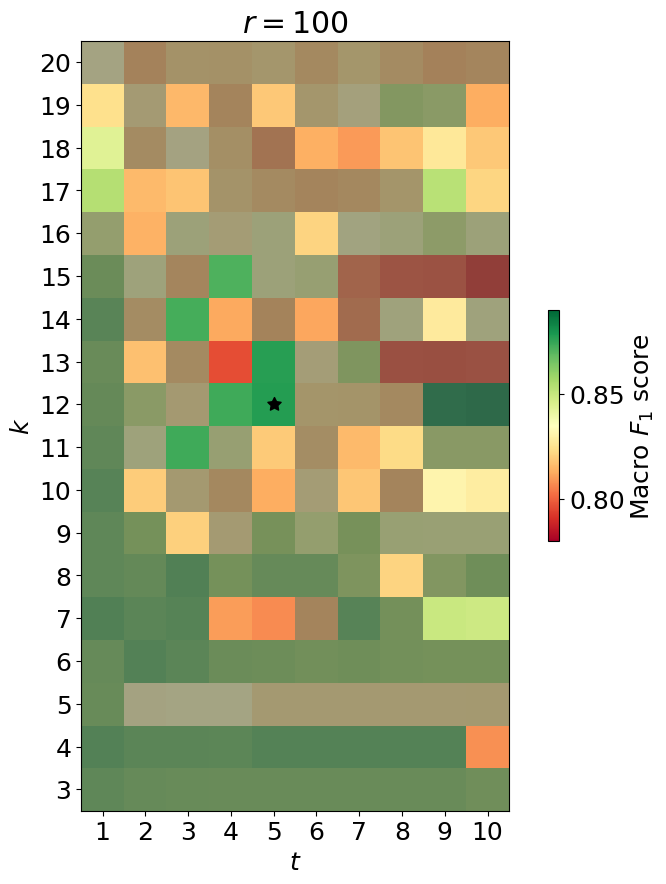

100%|██████████| 5/5 [00:40<00:00,  8.05s/it]


Number of discovered keywords: 45 

Semantic communities:

nigger --> ['nigger', 'walkaway', 'faggot', 'cunt', 'bitch', 'fag']
faggot --> ['faggot', 'nigger', 'walkaway', 'cunt', 'bitch', 'fag']
retard --> ['retard', 'retards', 'maggot']
retarded --> ['retarded']
cunt --> ['cunt', 'shite', 'nigga', 'wetback', 'pedo', 'motherfuckers', 'twat', 'cunts', 'raghead', 'braindead', 'woah', 'beaner', 'prob', 'skank', 'chinaman', 'shitty', 'turd', 'goyim', 'assholes', 'limey', 'badass', 'fuckin', 'faggots', 'wigger', 'spangle', 'stfu', 'commie', 'fucks', 'douche', 'thot', 'awww', 'fuckers', 'motherfucker', 'boobs', 'ummm', 'pilled', 'simp', 'btw', 'homos', 'commies', 'betas']

Discovered words: ['assholes', 'awww', 'badass', 'beaner', 'betas', 'bitch', 'boobs', 'braindead', 'btw', 'chinaman', 'commie', 'commies', 'cunts', 'douche', 'fag', 'faggots', 'fuckers', 'fuckin', 'fucks', 'goyim', 'homos', 'limey', 'maggot', 'motherfucker', 'motherfuckers', 'nigga', 'pedo', 'pilled', 'prob', 'raghead', '

In [42]:
########
# LGDE #
########

print("\n### LGDE ###\n")
print(f"Best hyperparameters at $r=100$:k={best_k_100d}, t={best_t_100d}")

# plot F1 score
fig, ax = plt.subplots(1, figsize=(10, 10))
im = ax.imshow(np.ones_like(fscore_lgde),cmap='Greys',origin='lower',alpha=0.7, vmin=0,vmax=1)
im = ax.imshow(fscore_lgde,cmap='RdYlGn',origin='lower',alpha=0.5,vmin=0.78,vmax=0.89)
im = ax.imshow(fscore_sc_lgde,cmap='RdYlGn',origin='lower',vmin=0.78,vmax=0.89)
ax.set(xlabel="$t$", ylabel="$k$", xticks=np.arange(len(times)),yticks=np.arange(len(ks)), xticklabels=times, yticklabels=ks)
ax.scatter(ind_lgde[1],ind_lgde[0],color='black',marker=(5, 1),s=100)
plt.colorbar(im,shrink=0.3,label="Macro $F_1$ score")
plt.title('$r=100$')
plt.savefig('figures/lgde_f1score-100d.pdf', bbox_inches='tight')
plt.show()

# expand with the optimal k and t
lgde_100d = LGDE(seed_dict,word_list,word_vecs_100d)
lgde_100d.expand(k=best_k_100d, t=best_t_100d)

print("\nNumber of discovered keywords:", lgde_100d.n_discovered,"\n")
print("Semantic communities:\n")
for keyword in lgde_100d.seed_dict[:10]:
    print(keyword,"-->",lgde_100d.semantic_communities_[keyword])

print("\nDiscovered words:", sorted(lgde_100d.discovered_dict_))

print("\nTrain scores for LGDE expanded dictionary at $r=100$:\n")
_,_,_ = evaluate_prediction(lgde_100d.expanded_dict_, y_train, dt_train)

print("\nTest scores for LGDE expanded dictionary at $r=100$:\n")
_,_,_ = evaluate_prediction(lgde_100d.expanded_dict_, y_test, dt_test)

In [43]:
print("### LGDE 100d ###\n")
error_analysis(lgde_100d, likelihood_ratio_positive)

### LGDE 100d ###

ERROR ANALYSIS DISCOVERED KWs:


LR                      Seed (sim)
betas     0.130205                    cunt (0.58) 
shitty    0.894866                   cunt (0.658) 
spangle   0.202542                   cunt (0.547) 
ummm      0.828580                   cunt (0.574) 
walkaway  0.862171  nigger (0.672) faggot (0.675) 
woah      0.221471                   cunt (0.644)

ERROR ANALYSIS SEED KWs:


Seed LR  # community  LR <= 1 (in %)     Min LR  Median LR  \
nigger    82.188888            6           16.67   0.862171  24.822828   
faggot    78.966956            6           16.67   0.862171  24.822828   
retard    18.069710            3            0.00   4.374901  15.862893   
retarded  15.096898            1            0.00  15.096898  15.096898   
cunt      15.922463           41           12.20   0.130205   2.734313   

            Mean LR     Max LR  # Inf LR  
nigger    36.127443  82.188888         0  
faggot    36.127443  82.188888         0  
retard    12.769168  18.069710         0  
retarded  15.096898  15.096898         0  
cunt       5.646944  34.741858         0

In [44]:
print("Size of semantic community of 'c**t'", len(lgde_100d.semantic_communities_["cunt"]))

Size of semantic community of 'c**t' 41


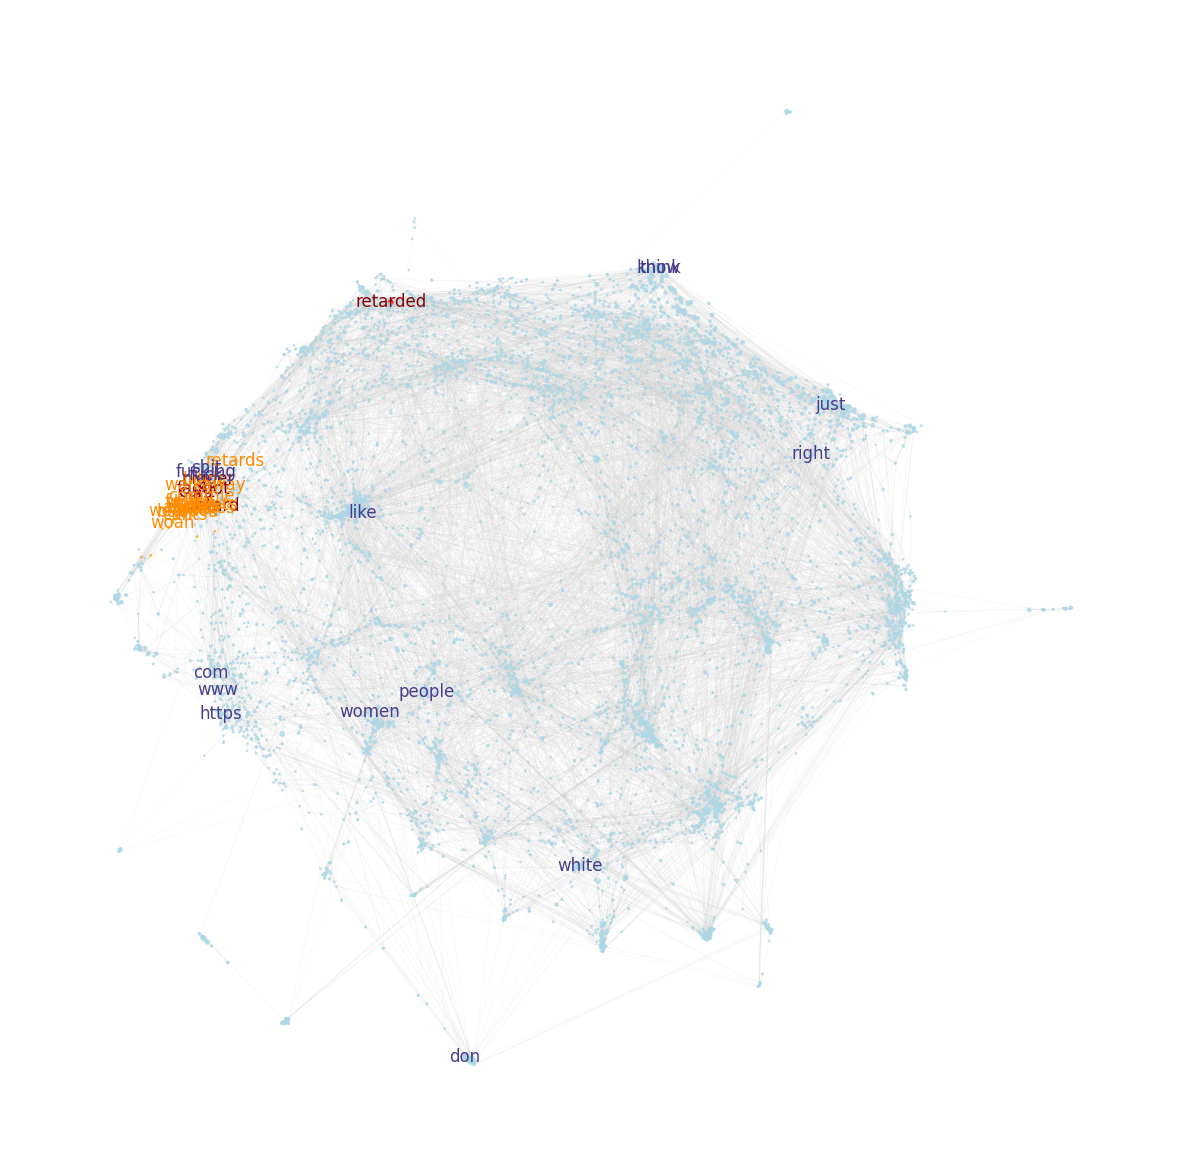

In [45]:
# visualise semantic network
lgde_100d.construct_nx_graph()
fig = lgde_100d.plot_semantic_network(n_top=15,doc_freq=list(doc_freq),lcc_only=True,node_size_factor=0.2,alpha=0.7,edge_width=0.1,plot_with_other_words=True)
fig.savefig("figures/redgab_semantic_network_100d.pdf",dpi=fig.dpi,bbox_inches="tight")

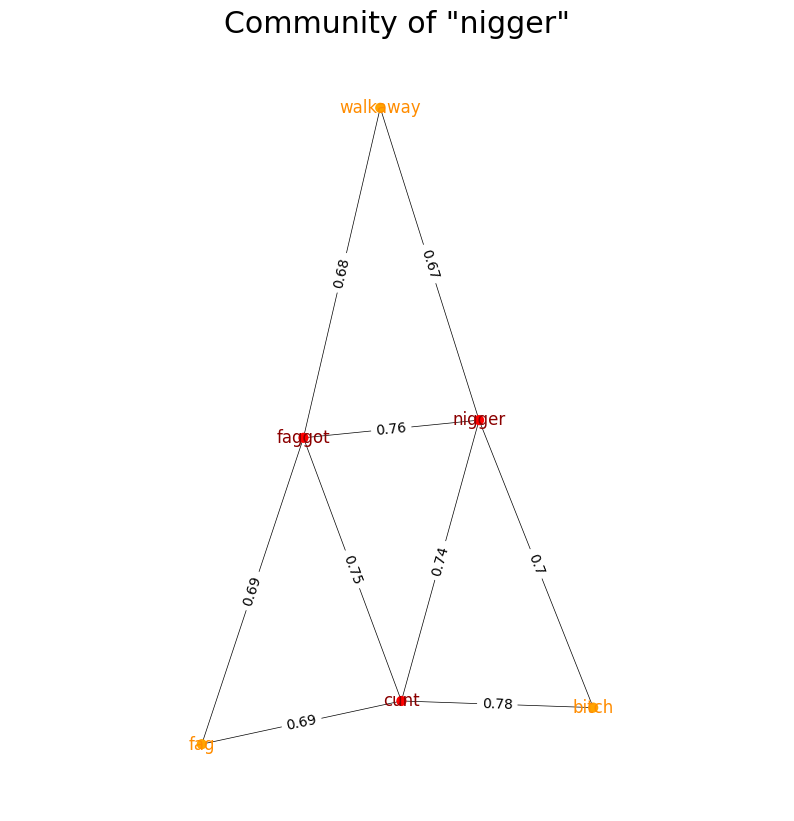

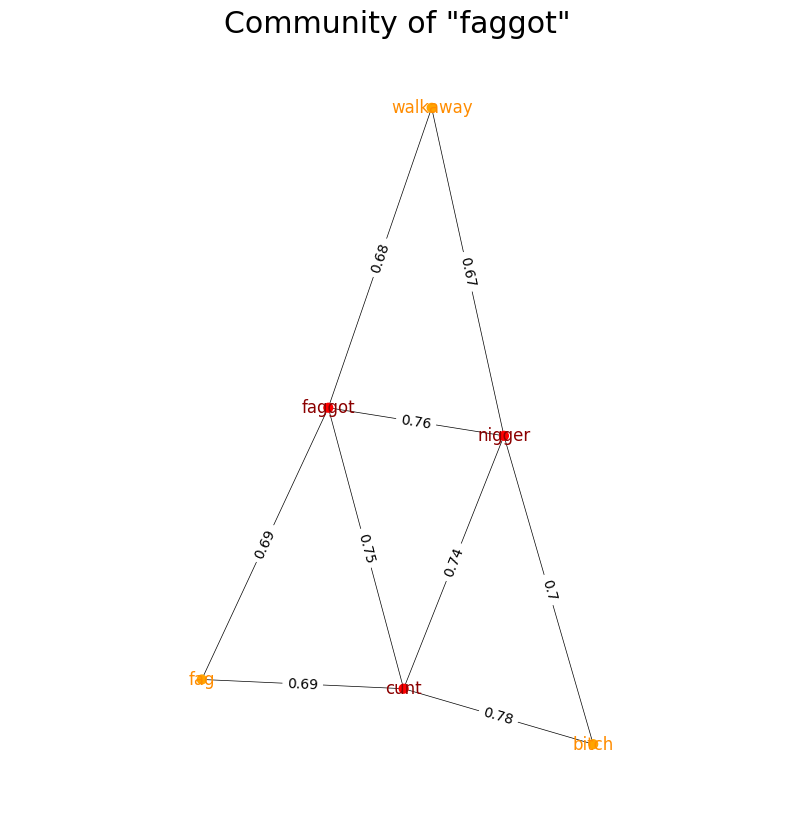

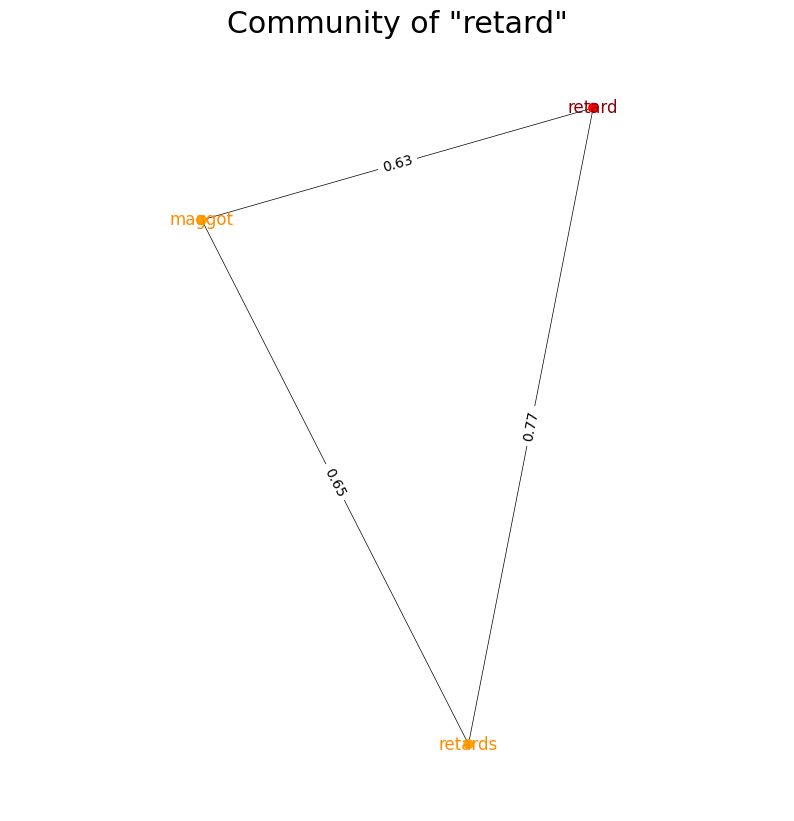

The keyword 'retarded' is a singleton semantic community.


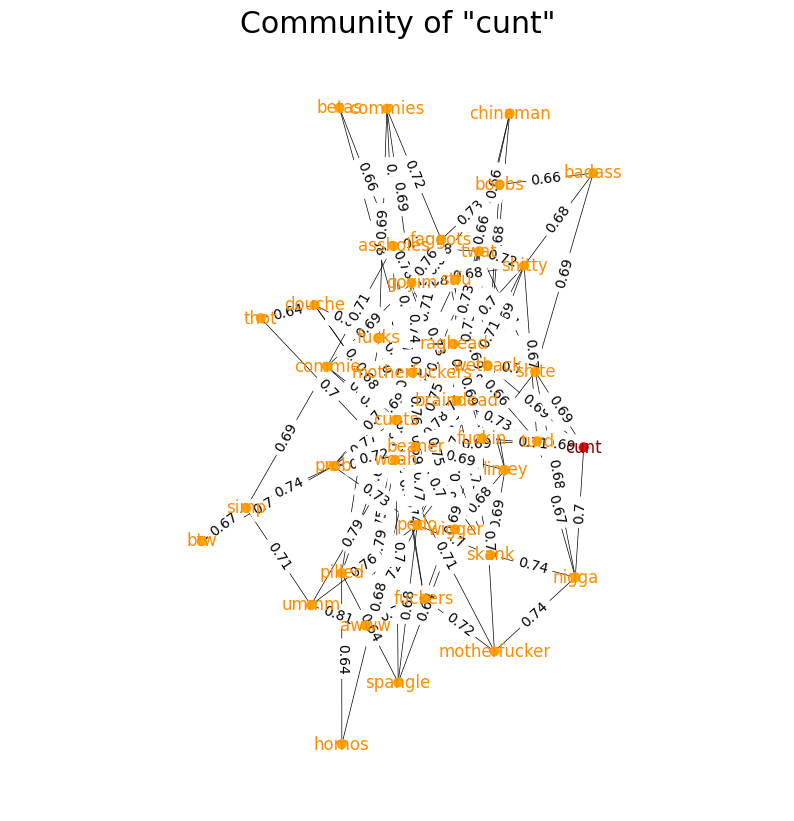

In [46]:
# plot semantic communities
lgde_100d.plot_semantic_communities(n_plots=5,figsize=(10,10),path="figures/100d-")

### 6.6) Significance tests

In [47]:
# get thresholding of same size as LGDE
eps_samesize = eps[np.argmin(size_th>len(lgde_100d.discovered_dict_))]
thres_100d_prime = Thresholding(seed_dict,word_list,word_vecs_100d)
thres_100d_prime.expand(eps_samesize)

# evaluate thresholding on test data
print("\nTest scores for same size thresholding expanded dictionary at $r=100$:\n")
_,_,_ = evaluate_prediction(thres_100d_prime.expanded_dict_, y_test, dt_test)

# determine which words are only found by LGDE or thresholding
lgde_only_100 =  list(set(lgde_100d.discovered_dict_) -  set(thres_100d_prime.discovered_dict_))
thres_only_100_prime = list(set(thres_100d_prime.discovered_dict_) - set(lgde_100d.discovered_dict_))

print("\nCOMPARISON BETWEEN BEST LGDE AND BEST THRESHOLDING OF SAME SIZE")

print("\nMedian LR+ Thresholding:", round(np.median(likelihood_ratio_positive[thres_only_100_prime]),2))
print("Median LR+ LGDE:", round(np.median(likelihood_ratio_positive[lgde_only_100]),2))
U, p = mannwhitneyu(likelihood_ratio_positive[lgde_only_100],likelihood_ratio_positive[thres_only_100_prime],alternative='greater',method='exact')
print('Mann-Whitney U test with alternative "greater": p =', np.around(p,5))

# free up memory
del thres_100d_prime
del thres_only_100_prime


Test scores for same size thresholding expanded dictionary at $r=100$:

              precision    recall  f1-score   support

       False      0.893     0.880     0.887      9057
        True      0.787     0.808     0.798      4968

    accuracy                          0.855     14025
   macro avg      0.840     0.844     0.842     14025
weighted avg      0.856     0.855     0.855     14025


COMPARISON BETWEEN BEST LGDE AND BEST THRESHOLDING OF SAME SIZE

Median LR+ Thresholding: 1.53
Median LR+ LGDE: 2.59
Mann-Whitney U test with alternative "greater": p = 0.01909


In [48]:
#######
# kNN #
#######

# get kNN of same size as LGDE
ks_knn_samesize = ks_knn[np.argmin(np.abs(size_knn - len(lgde_100d.discovered_dict_)))]
knn_100d_prime = KNearestNeighbors(seed_dict,word_list,word_vecs_100d)
knn_100d_prime.expand(ks_knn_samesize)

# determine which words are only found by LGDE or kNN
lgde_only_100 =  list(set(lgde_100d.discovered_dict_) -  set(knn_100d_prime.discovered_dict_))
knn_only_100d_prime = list(set(knn_100d_prime.discovered_dict_) - set(lgde_100d.discovered_dict_))

print("\nCOMPARISON BETWEEN BEST LGDE AND BEST kNN OF SAME SIZE")

print("\nMedian LR+ kNN:", round(np.median(likelihood_ratio_positive[knn_only_100d_prime]),2))
print("Median LR+ LGDE:", round(np.median(likelihood_ratio_positive[lgde_only_100]),2))
U, p = mannwhitneyu(likelihood_ratio_positive[lgde_only_100],likelihood_ratio_positive[knn_only_100d_prime],alternative='greater',method='exact')
print('Mann-Whitney U test with alternative "greater": p =', np.around(p,5))

# free up memory
del knn_100d_prime

########
# IKEA #
########

# get IKEA of same size as LGDE
eps_ikea_samesize = eps_ikea[np.argmin(np.abs(size_ikea - len(lgde_100d.discovered_dict_)))] 
ikea_100d_prime = IKEA(seed_dict,word_list,word_vecs_100d)
ikea_100d_prime.expand(eps_ikea_samesize)

# determine which words are only found by LGDE or IKEA
lgde_only_100 =  list(set(lgde_100d.discovered_dict_) -  set(ikea_100d_prime.discovered_dict_))
ikea_only_100d_prime = list(set(ikea_100d_prime.discovered_dict_) - set(lgde_100d.discovered_dict_))

print("\nCOMPARISON BETWEEN BEST LGDE AND BEST IKEA OF SAME SIZE")

print("\nMedian LR+ IKEA:", round(np.median(likelihood_ratio_positive[ikea_only_100d_prime]),2))
print("Median LR+ LGDE:", round(np.median(likelihood_ratio_positive[lgde_only_100]),2))
U, p = mannwhitneyu(likelihood_ratio_positive[lgde_only_100],likelihood_ratio_positive[ikea_only_100d_prime],alternative='greater',method='exact')
print('Mann-Whitney U test with alternative "greater": p =', np.around(p,5))

# free up memory
del ikea_100d_prime

############
# TextRank #
############

# get TextRank of same size as LGDE
ind_tr_samesize = np.argmin(np.abs(size_tr[ind_tr[0]] - len(lgde_100d.discovered_dict_)))
tr_100d_prime = discovered_dicts_tr[ind_tr[0]][ind_tr_samesize]

# determine which words are only found by LGDE or TextRank
lgde_only_100 =  list(set(lgde_100d.discovered_dict_) -  set(tr_100d_prime))
tr_only_100d_prime = list(set(tr_100d_prime) - set(lgde_100d.discovered_dict_))

print("\nCOMPARISON BETWEEN BEST LGDE AND BEST TextRank OF SAME SIZE")

print("\nMedian LR+ TextRank:", round(np.median(likelihood_ratio_positive[tr_only_100d_prime]),2))
print("Median LR+ LGDE:", round(np.median(likelihood_ratio_positive[lgde_only_100]),2))
U, p = mannwhitneyu(likelihood_ratio_positive[lgde_only_100],likelihood_ratio_positive[tr_only_100d_prime],alternative='greater',method='exact')
print('Mann-Whitney U test with alternative "greater": p =', np.around(p,7))


COMPARISON BETWEEN BEST LGDE AND BEST kNN OF SAME SIZE

Median LR+ kNN: 1.46
Median LR+ LGDE: 2.59
Mann-Whitney U test with alternative "greater": p = 0.00901

COMPARISON BETWEEN BEST LGDE AND BEST IKEA OF SAME SIZE

Median LR+ IKEA: 1.44
Median LR+ LGDE: 2.73
Mann-Whitney U test with alternative "greater": p = 0.00014

COMPARISON BETWEEN BEST LGDE AND BEST TextRank OF SAME SIZE

Median LR+ TextRank: 1.03
Median LR+ LGDE: 2.79
Mann-Whitney U test with alternative "greater": p = 0.0


## 7) Detailed comparison for dimension $r=300$

In [19]:
##############
# GS results #
##############

# unpack results for thresholding
eps = results_300d["th"]["eps"]
fscore_th = results_300d["th"]["fscore"]
precision_th = results_300d["th"]["precision"]
recall_th = results_300d["th"]["recall"]
size_th = results_300d["th"]["size"]

# unpack results for kNN
ks_knn = results_300d["knn"]["ks"]
fscore_knn = results_300d["knn"]["fscore"]
precision_knn = results_300d["knn"]["precision"]
recall_knn = results_300d["knn"]["recall"]
size_knn = results_300d["knn"]["size"]

# unpack results_300d for IKEA
eps_ikea = results_300d["ikea"]["eps"]
fscore_ikea = results_300d["ikea"]["fscore"]
precision_ikea = results_300d["ikea"]["precision"]
recall_ikea = results_300d["ikea"]["recall"]
size_ikea = results_300d["ikea"]["size"]

# unpack results_300d for LGDE with LSWL
ks_lswl = results_300d["lswl"]["ks"]
fscore_lswl = results_300d["lswl"]["fscore"]
precision_lswl = results_300d["lswl"]["precision"]
recall_lswl = results_300d["lswl"]["recall"]
size_lswl = results_300d["lswl"]["size"]

# unpack results for LGDE
times = results_300d["lgde"]["times"]
ks = results_300d["lgde"]["ks"]
commmunities = results_300d["lgde"]["communities"]
fscore_lgde = results_300d["lgde"]["fscore"]
precision_lgde = results_300d["lgde"]["precision"]
recall_lgde = results_300d["lgde"]["recall"]
size_lgde = results_300d["lgde"]["size"]

# apply size constraints to thresholding
fscore_sc_th = fscore_th.copy()
fscore_sc_th[min_size > size_th] = np.nan
fscore_sc_th[size_th > max_size] = np.nan

# apply size constraints to kNN
fscore_sc_knn = fscore_knn.copy()
fscore_sc_knn[min_size > size_knn] = np.nan
fscore_sc_knn[size_knn > max_size] = np.nan

# apply size constraints to IKEA
fscore_sc_ikea = fscore_ikea.copy()
fscore_sc_ikea[min_size > size_ikea] = np.nan
fscore_sc_ikea[size_ikea > 60] = np.nan # exception for IKEA because of gap

# apply size constraints to LGDE with LSWL
fscore_sc_lswl = fscore_lswl.copy()
fscore_sc_lswl[min_size > size_lswl] = np.nan
fscore_sc_lswl[size_lswl > max_size] = np.nan

# apply size constraints to lgde
fscore_sc_lgde = fscore_lgde.copy()
for ind_pair in np.argwhere(size_lgde < min_size):
    fscore_sc_lgde[ind_pair[0],ind_pair[1]] = np.nan
for ind_pair in np.argwhere(size_lgde > max_size):
    fscore_sc_lgde[ind_pair[0],ind_pair[1]] = np.nan

# compute best thresholding hyperparameter
ind_th = np.nanargmax(fscore_sc_th)
best_epsilon_300d = eps[ind_th]

# compute best knn hyperparameter
ind_knn = np.nanargmax(fscore_sc_knn)
best_k_300d_knn = ks_knn[ind_knn]

# compute best IKEA hyperparameter
ind_ikea = np.nanargmax(fscore_sc_ikea)
best_epsilon_300d_ikea = eps_ikea[ind_ikea]

# compute best lswl hyperparameter
ind_lswl = np.nanargmax(fscore_sc_lswl)
best_k_300d_lswl = ks_lswl[ind_lswl]

# compute best LGDE hyperparamers
ind_lgde = tuple(np.argwhere(fscore_sc_lgde == np.nanmax(fscore_sc_lgde))[0])
best_k_300d = ks[ind_lgde[0]]
best_t_300d = times[ind_lgde[1]]

### 7.1) Thresholding


### Thresholding ###

Best epsilon at $r=50$: 0.552


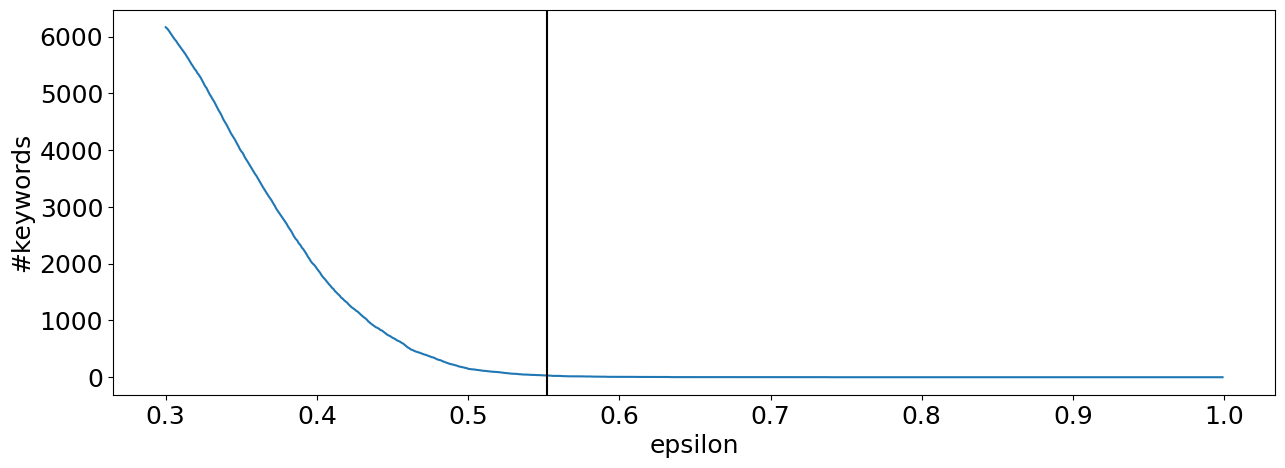

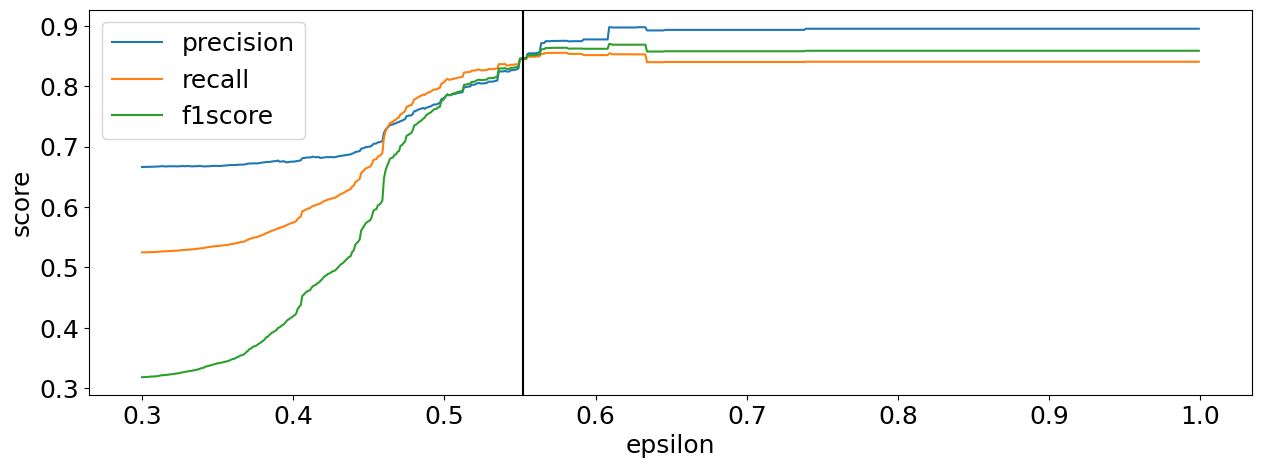

Number of discovered keywords at $r=50$: 31 

Epsilon balls:

nigger --> ['nigger', 'fucking', 'niggers', 'faggot', 'word', 'bitch', 'derogatory', 'fag', 'slur', 'nigga']
faggot --> ['nigger', 'fucking', 'faggot', 'ugh', 'simp', 'aww', 'awww', 'ahhh']
retard --> ['retard', 'retards']
retarded --> ['retarded', 'mental', 'murderers', 'cruel', 'mentally', 'convicted', 'autistic', 'incompetent', 'mildly', 'competent', 'retardation', 'offenders', 'cared', 'disabled', 'execution', 'execute', 'executed']
cunt --> ['fucking', 'fuck', 'cunt', 'bitch']

Discovered words: ['ahhh', 'autistic', 'aww', 'awww', 'bitch', 'cared', 'competent', 'convicted', 'cruel', 'derogatory', 'disabled', 'execute', 'executed', 'execution', 'fag', 'fuck', 'fucking', 'incompetent', 'mental', 'mentally', 'mildly', 'murderers', 'nigga', 'niggers', 'offenders', 'retardation', 'retards', 'simp', 'slur', 'ugh', 'word']

Train scores for thresholding expanded dictionary at $r=50$:

              precision    recall  f1-scor

In [20]:
################
# Thresholding #
################

print("\n### Thresholding ###\n")

print("Best epsilon at $r=50$:",round(best_epsilon_300d,3))

# plot size
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(eps,size_th)
ax.axvline(x=best_epsilon_300d, c = 'black')
ax.set(xlabel="epsilon", ylabel="#keywords")
plt.show()

# plot F1
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(eps,precision_th,label="precision")
ax.plot(eps,recall_th,label="recall")
ax.plot(eps,fscore_th,label="f1score")
ax.axvline(x=best_epsilon_300d, c = 'black')
ax.set(xlabel="epsilon",ylabel="score")
ax.legend()
plt.show()

# expand with the optimal epsilon
thres_300d = Thresholding(seed_dict,word_list,word_vecs_300d)
thres_300d.expand(best_epsilon_300d)

print("Number of discovered keywords at $r=50$:", thres_300d.n_discovered,"\n")

print("Epsilon balls:\n")
for keyword in thres_300d.seed_dict[:15]:
    print(keyword,"-->",thres_300d.epsilon_balls_[keyword])

print("\nDiscovered words:", sorted(thres_300d.discovered_dict_))

print("\nTrain scores for thresholding expanded dictionary at $r=50$:\n")
_,_,_ =  evaluate_prediction(thres_300d.expanded_dict_, y_train, dt_train)

print("\nTest scores for thresholding expanded dictionary at $r=50$:\n")
_,_,_ = evaluate_prediction(thres_300d.expanded_dict_, y_test, dt_test)

In [21]:
# compute max similarity of tr**ny with seed keywords
max_sim = np.around(np.array([thres_300d.pairwise_word_similarity("tranny",kw) for kw in seed_dict]).max(),3)
# compute size of corresponding thresholding dict
thres_300d.expand(max_sim)
# get size of expanded dictionary
print(f"Epsilon {max_sim} and size {len(thres_300d.discovered_dict_)}.")
print("\nTest scores:\n")
_,_,_ = evaluate_prediction(thres_300d.expanded_dict_, y_test, dt_test)

Epsilon 0.485 and size 263.

Test scores:

              precision    recall  f1-score   support

       False      0.928     0.654     0.768      9057
        True      0.590     0.908     0.715      4968

    accuracy                          0.744     14025
   macro avg      0.759     0.781     0.741     14025
weighted avg      0.809     0.744     0.749     14025



### 7.2) kNN


### kNN ###

Best k at $r=300$: 8


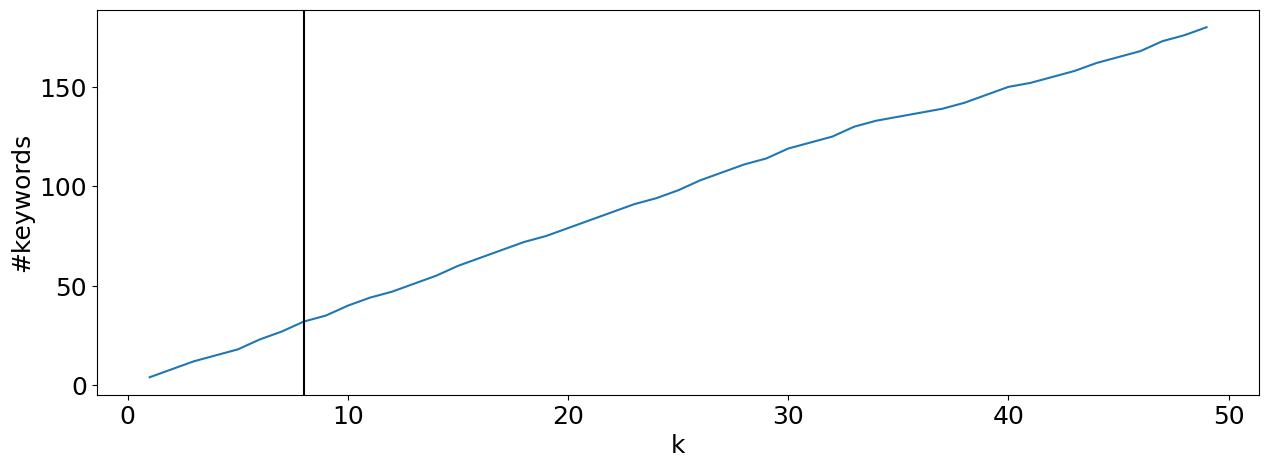

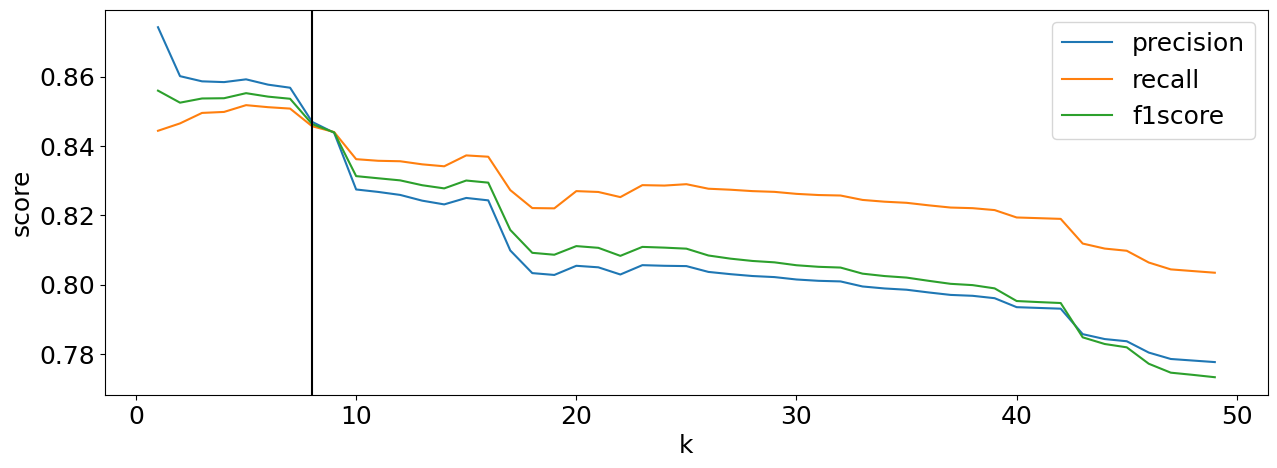

Number of discovered keywords at $r=300$: 32 

k-nearest neighbors:

nigger --> ['nigger', 'slur', 'niggers', 'faggot', 'bitch', 'fag', 'derogatory', 'fucking', 'word']
faggot --> ['faggot', 'nigger', 'ahhh', 'aww', 'ugh', 'fucking', 'simp', 'awww', 'imbecile']
retard --> ['retard', 'retards', 'retarded', 'bleed', 'niggas', 'fuckers', 'wont', 'starve', 'undermine']
retarded --> ['retarded', 'mentally', 'autistic', 'retardation', 'offenders', 'murderers', 'mildly', 'execution', 'mental']
cunt --> ['cunt', 'fucking', 'fuck', 'bitch', 'nigger', 'faggot', 'nigga', 'scumbag', 'moronic']

Discovered words: ['ahhh', 'autistic', 'aww', 'awww', 'bitch', 'bleed', 'derogatory', 'execution', 'fag', 'fuck', 'fuckers', 'fucking', 'imbecile', 'mental', 'mentally', 'mildly', 'moronic', 'murderers', 'nigga', 'niggas', 'niggers', 'offenders', 'retardation', 'retards', 'scumbag', 'simp', 'slur', 'starve', 'ugh', 'undermine', 'wont', 'word']

Train scores for kNN expanded dictionary at $r=50$:

          

In [22]:
#######
# kNN #
#######

print("\n### kNN ###\n")

print("Best k at $r=300$:",round(best_k_300d_knn,3))

# plot size
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(ks_knn,size_knn)
ax.axvline(x=best_k_300d_knn, c = 'black')
ax.set(xlabel="k", ylabel="#keywords")
plt.show()

# plot F1
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(ks_knn,precision_knn,label="precision")
ax.plot(ks_knn,recall_knn,label="recall")
ax.plot(ks_knn,fscore_knn,label="f1score")
ax.axvline(x=best_k_300d_knn, c = 'black')
ax.set(xlabel="k",ylabel="score")
ax.legend()
plt.show()

# expand with the optimal k
knn_300d = KNearestNeighbors(seed_dict,word_list,word_vecs_300d)
knn_300d.expand(best_k_300d_knn)

print("Number of discovered keywords at $r=300$:", knn_300d.n_discovered,"\n")

print("k-nearest neighbors:\n")
for keyword in knn_300d.seed_dict[:15]:
    print(keyword,"-->",knn_300d.neighbors_[keyword])

print("\nDiscovered words:", sorted(knn_300d.discovered_dict_))

print("\nTrain scores for kNN expanded dictionary at $r=50$:\n")
_,_,_ =  evaluate_prediction(knn_300d.expanded_dict_, y_train, dt_train)

print("\nTest scores for kNN expanded dictionary at $r=50$:\n")
_,_,_ = evaluate_prediction(knn_300d.expanded_dict_, y_test, dt_test)

### 7.3) IKEA


### IKEA ###

Best epsilon at $r=300$: 0.507


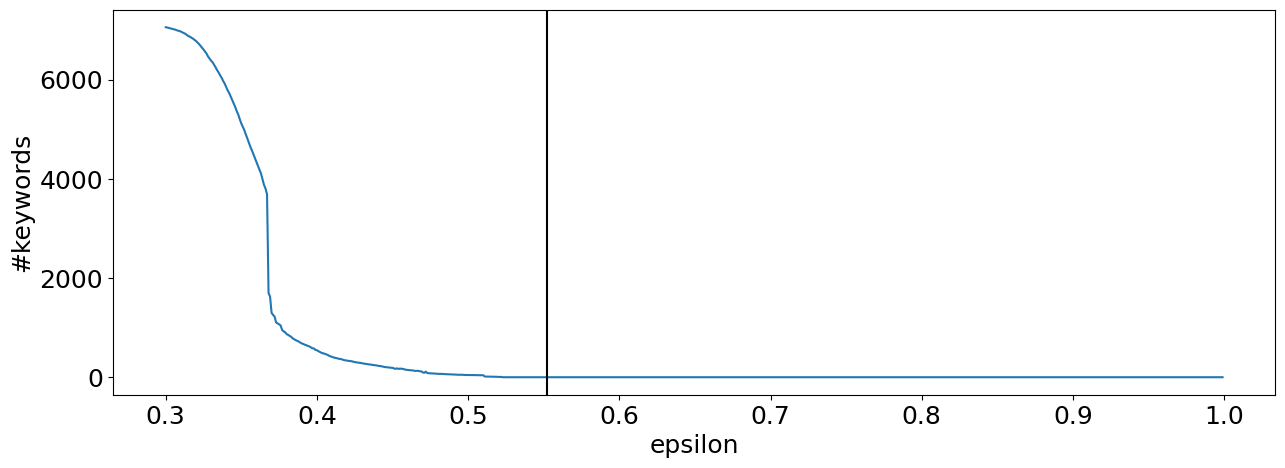

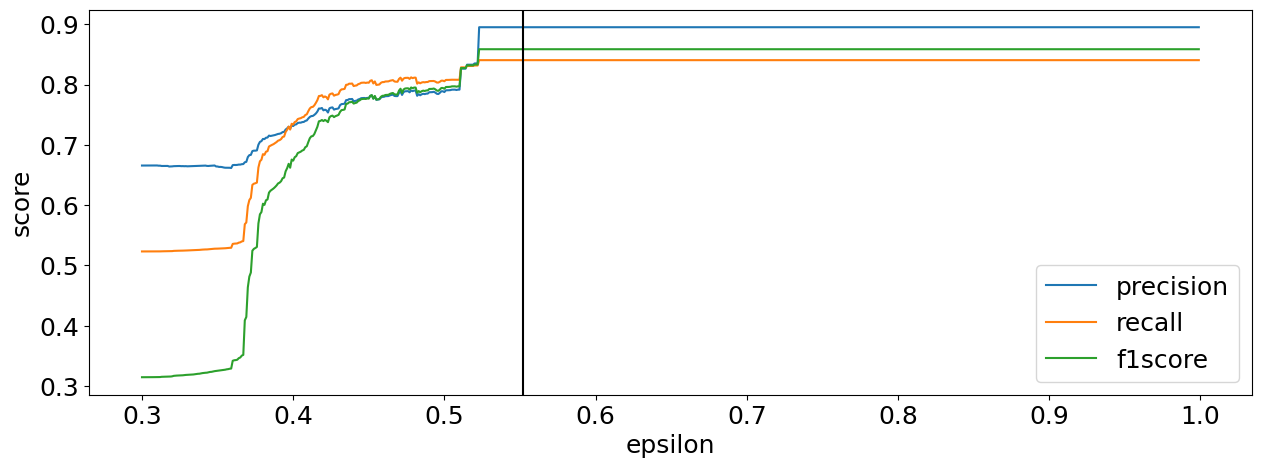

Number of discovered keywords at $r=300$: 40 


Discovered words: ['ass', 'asshole', 'bastard', 'bastards', 'bitch', 'bullshit', 'crap', 'damn', 'damned', 'dude', 'freaking', 'fuck', 'fuckin', 'fucking', 'goddamn', 'gonna', 'gotta', 'heck', 'hey', 'hmmm', 'hmmmm', 'idiotic', 'kidding', 'kinda', 'messed', 'moronic', 'motherfucker', 'nigga', 'nope', 'oops', 'outta', 'pretentious', 'shit', 'stupid', 'ugh', 'whoa', 'whore', 'yeah', 'yep', 'yikes']

Train scores for IKEA expanded dictionary at $r=50$:

              precision    recall  f1-score   support

       False      0.884     0.810     0.845     27169
        True      0.700     0.806     0.749     14905

    accuracy                          0.809     42074
   macro avg      0.792     0.808     0.797     42074
weighted avg      0.819     0.809     0.811     42074


Test scores for IKEA expanded dictionary at $r=50$:

              precision    recall  f1-score   support

       False      0.880     0.809     0.843      9057
       

In [23]:
########
# IKEA #
########

print("\n### IKEA ###\n")

print("Best epsilon at $r=300$:",round(best_epsilon_300d_ikea,3))

# plot size
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(eps,size_ikea)
ax.axvline(x=best_epsilon_300d, c = 'black')
ax.set(xlabel="epsilon", ylabel="#keywords")
plt.show()

# plot F1
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(eps,precision_ikea,label="precision")
ax.plot(eps,recall_ikea,label="recall")
ax.plot(eps,fscore_ikea,label="f1score")
ax.axvline(x=best_epsilon_300d, c = 'black')
ax.set(xlabel="epsilon",ylabel="score")
ax.legend()
plt.show()

# expand with the optimal epsilon
ikea_300d = IKEA(seed_dict,word_list,word_vecs_300d)
ikea_300d.expand(best_epsilon_300d_ikea)

print("Number of discovered keywords at $r=300$:", ikea_300d.n_discovered,"\n")

print("\nDiscovered words:", sorted(ikea_300d.discovered_dict_))

print("\nTrain scores for IKEA expanded dictionary at $r=50$:\n")
_,_,_ =  evaluate_prediction(ikea_300d.expanded_dict_, y_train, dt_train)

print("\nTest scores for IKEA expanded dictionary at $r=50$:\n")
_,_,_ = evaluate_prediction(ikea_300d.expanded_dict_, y_test, dt_test)

### 7.4) Other local community detection methods


### LSWL / SIWO ###

Best k at $r=300$: 5


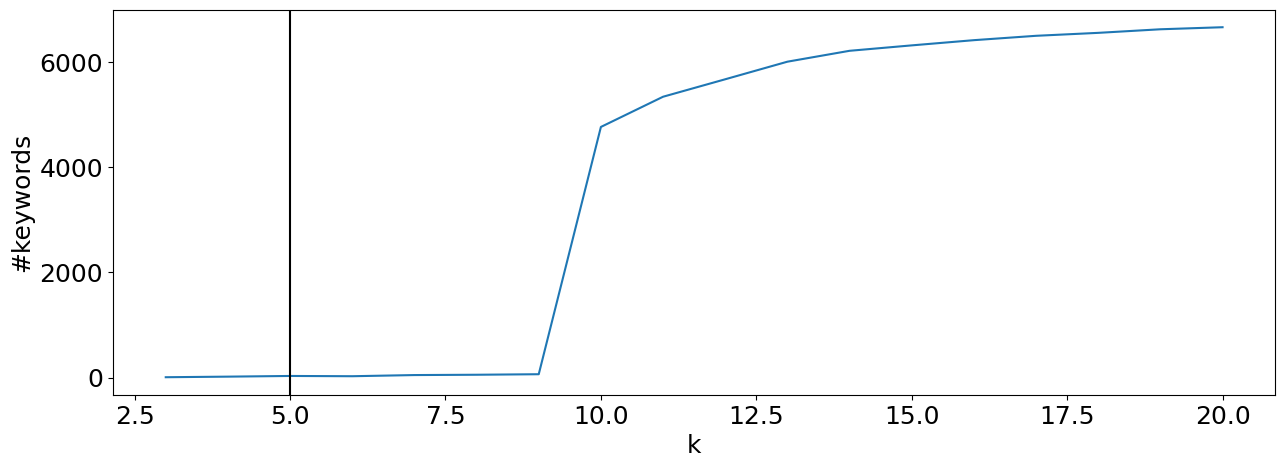

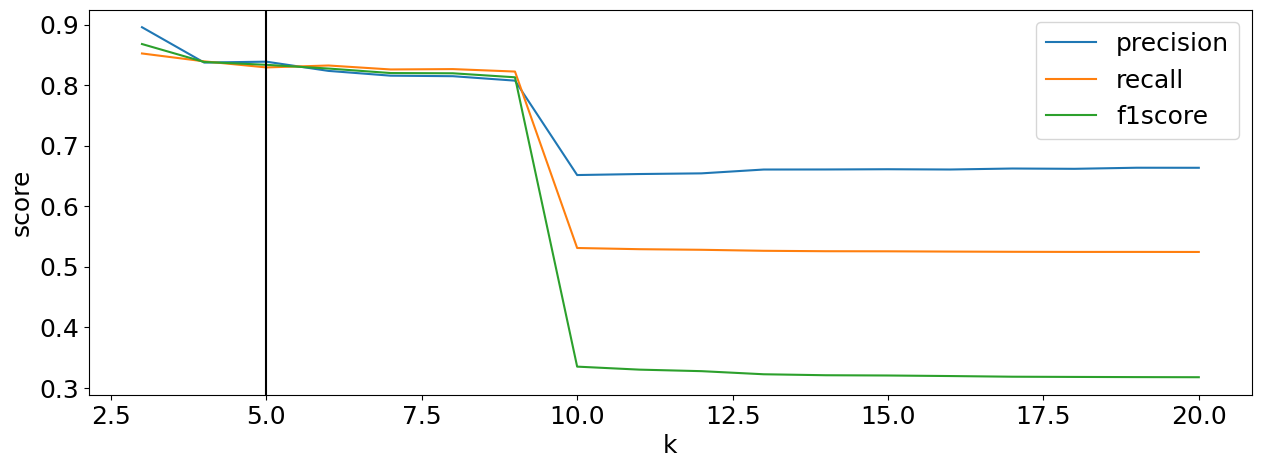

100%|██████████| 5/5 [00:00<00:00, 175.95it/s]

Number of discovered keywords at $r=300$: 30 

Semantic communities:

nigger --> ['nigger', 'misogyny', 'racist', 'sexist', 'derogatory', 'bigoted', 'slurs', 'semitic', 'slur', 'homophobic', 'misogynist', 'misogynistic', 'antisemitic', 'xenophobic']
faggot --> ['faggot', 'gg', 'ugh', 'aww', 'awww', 'ahhh']
retard --> ['retard', 'retards', 'potus']
retarded --> ['retarded', 'emotionally', 'physically', 'mentally', 'financially', 'intellectually', 'verbally']
cunt --> ['fucking', 'cunt', 'asshole', 'fuckin', 'motherfucker']

Discovered words: ['ahhh', 'antisemitic', 'asshole', 'aww', 'awww', 'bigoted', 'derogatory', 'emotionally', 'financially', 'fuckin', 'fucking', 'gg', 'homophobic', 'intellectually', 'mentally', 'misogynist', 'misogynistic', 'misogyny', 'motherfucker', 'physically', 'potus', 'racist', 'retards', 'semitic', 'sexist', 'slur', 'slurs', 'ugh', 'verbally', 'xenophobic']

Train scores for LSWL expanded dictionary at $r=300$:

              precision    recall  f1-score   su

In [24]:
########
# LSWL #
########

print("\n### LSWL / SIWO ###\n")

print("Best k at $r=300$:",round(best_k_300d_lswl,3))

# plot size
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(ks_lswl,size_lswl)
ax.axvline(x=best_k_300d_lswl, c = 'black')
ax.set(xlabel="k", ylabel="#keywords")
plt.show()

# plot F1
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(ks_lswl,precision_lswl,label="precision")
ax.plot(ks_lswl,recall_lswl,label="recall")
ax.plot(ks_lswl,fscore_lswl,label="f1score")
ax.axvline(x=best_k_300d_lswl, c = 'black')
ax.set(xlabel="k",ylabel="score")
ax.legend()
plt.show()

# expand with the optimal k
lswl_300d = LGDEWithCDlib(seed_dict,word_list,word_vecs_300d)
lswl_300d.expand(best_k_300d_lswl, method="lswl")

print("Number of discovered keywords at $r=300$:", lswl_300d.n_discovered,"\n")

print("Semantic communities:\n")
for keyword in lswl_300d.seed_dict[:15]:
    print(keyword,"-->",lswl_300d.semantic_communities_[keyword])

print("\nDiscovered words:", sorted(lswl_300d.discovered_dict_))

print("\nTrain scores for LSWL expanded dictionary at $r=300$:\n")
_,_,_ =  evaluate_prediction(lswl_300d.expanded_dict_, y_train, dt_train)

print("\nTest scores for LSWL expanded dictionary at $r=300$:\n")
_,_,_ = evaluate_prediction(lswl_300d.expanded_dict_, y_test, dt_test)

In [25]:
#########
# Mod R #
#########

# unpack dictionary
modr_size = results_localmod_300d["modr"]["size"]
modr_fscore_train = results_localmod_300d["modr"]["fscore_train"]
modr_fscore_test = results_localmod_300d["modr"]["fscore_test"]
modr_ks = results_localmod_300d["modr"]["ks"]

# apply size constraints
modr_fscore_train_sc = []
modr_fscore_test_sc = []

for i in range(len(modr_ks)):
    # comput size constraint indices per k
    sc_ind = (modr_size[i] <= max_size) * (modr_size[i] >= min_size)
    modr_fscore_train_sc.append(modr_fscore_train[i][sc_ind])
    modr_fscore_test_sc.append(modr_fscore_test[i][sc_ind])

# find best k based on mean train F1 scores of admissible dictionaries
modr_fscore_train_sc_mean = np.array([np.array(scores_k).mean() if len(scores_k) > 0 else np.nan for scores_k in modr_fscore_train_sc])
modr_best_k_ind = np.nanargmax(modr_fscore_train_sc_mean) # best k only has 2 admissible dictionaries, we choose second-best below
modr_best_k_ind = np.argsort(-modr_fscore_train_sc_mean)[1]
modr_best_k = modr_ks[modr_best_k_ind]
print("Best k for 'modr':",modr_best_k)
print("Number of admissible dictionaries:", len(modr_fscore_train_sc[modr_best_k_ind]))

# compute 95% CIs for train and test F1 scores
modr_fscore_train_m, modr_fscore_train_l, modr_fscore_train_r = mean_confidence_interval(modr_fscore_train_sc[modr_best_k_ind])
print(f"Average train F1 score for 'modr': {modr_fscore_train_m} ({modr_fscore_train_l}--{modr_fscore_train_r})")
modr_fscore_test_m, modr_fscore_test_l, modr_fscore_test_r = mean_confidence_interval(modr_fscore_test_sc[modr_best_k_ind])
print(f"Average test F1 score for 'modr': {modr_fscore_test_m} ({modr_fscore_test_l}--{modr_fscore_test_r})")

#########
# Mod M #
#########

# unpack dictionary
modm_size = results_localmod_300d["modm"]["size"]
modm_fscore_train = results_localmod_300d["modm"]["fscore_train"]
modm_fscore_test = results_localmod_300d["modm"]["fscore_test"]
modm_ks = results_localmod_300d["modm"]["ks"]

# apply size constraints
modm_fscore_train_sc = []
modm_fscore_test_sc = []

for i in range(len(modm_ks)):
    # comput size constraint indices per k
    sc_ind = (modm_size[i] <= max_size) * (modm_size[i] >= min_size)
    modm_fscore_train_sc.append(modm_fscore_train[i][sc_ind])
    modm_fscore_test_sc.append(modm_fscore_test[i][sc_ind])

# find best k based on mean train F1 scores of admissible dictionaries
modm_fscore_train_sc_mean = np.array([np.array(scores_k).mean() if len(scores_k) > 0 else np.nan for scores_k in modm_fscore_train_sc])
modm_best_k_ind = np.nanargmax(modm_fscore_train_sc_mean)
modm_best_k = modm_ks[modm_best_k_ind]
print("\nBest k for 'modm':",modm_best_k)
print("Number of admissible dictionaries:", len(modm_fscore_train_sc[modm_best_k_ind]))

# compute 95% CIs for train and test F1 scores
modm_fscore_train_m, modm_fscore_train_l, modm_fscore_train_r = mean_confidence_interval(modm_fscore_train_sc[modm_best_k_ind])
print(f"Average train F1 score for 'modm': {modm_fscore_train_m} ({modm_fscore_train_l}--{modm_fscore_train_r})")
modm_fscore_test_m, modm_fscore_test_l, modm_fscore_test_r = mean_confidence_interval(modm_fscore_test_sc[modm_best_k_ind])
print(f"Average test F1 score for 'modm': {modm_fscore_test_m} ({modm_fscore_test_l}--{modm_fscore_test_r})")

Best k for 'modr': 17
Number of admissible dictionaries: 38
Average train F1 score for 'modr': 0.854 (0.853--0.855)
Average test F1 score for 'modr': 0.852 (0.851--0.853)

Best k for 'modm': 7
Number of admissible dictionaries: 26
Average train F1 score for 'modm': 0.865 (0.864--0.866)
Average test F1 score for 'modm': 0.862 (0.861--0.863)


### 7.5) LGDE


### LGDE ###

Best hyperparameters at $r=300$:k=19, t=2


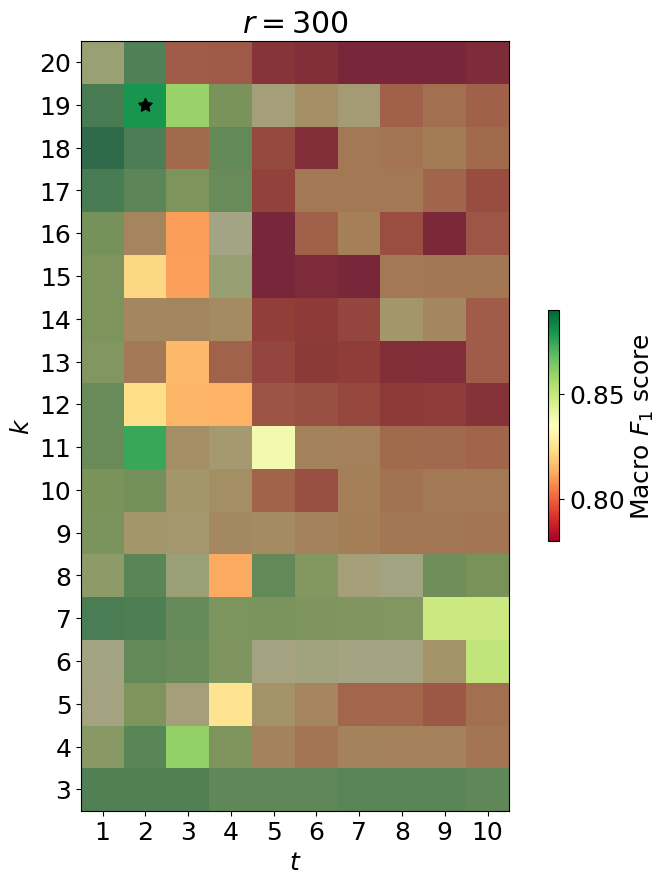

100%|██████████| 5/5 [01:58<00:00, 23.71s/it]


Number of discovered keywords: 38 

Semantic communities:

nigger --> ['nigger']
faggot --> ['faggot', 'twat', 'cunt', 'wetback', 'raghead', 'shite', 'woah', 'pedo', 'beaner', 'cunts', 'fucker', 'awww', 'skank', 'douche', 'braindead', 'scumbag', 'wigger', 'goyim', 'simp', 'homos', 'aww', 'faggots', 'stfu', 'foxnews', 'ummm', 'thot', 'nigga', 'motherfucker', 'motherfuckers', 'fuckers', 'commies']
retard --> ['retard', 'retards', 'goalposts', 'misandry', 'brainwashing', 'potus', 'btw', 'tranny', 'retardation', 'shite', 'sucks', 'faggots']
retarded --> ['retarded']
cunt --> ['cunt', 'twat', 'wetback', 'faggot', 'raghead', 'shite', 'woah', 'pedo', 'beaner', 'cunts', 'fucker', 'awww', 'skank', 'douche', 'braindead', 'scumbag', 'wigger', 'goyim', 'simp', 'homos', 'aww', 'faggots', 'stfu', 'foxnews', 'ummm', 'thot', 'nigga', 'motherfucker', 'motherfuckers', 'fuckers', 'commies']

Discovered words: ['aww', 'awww', 'beaner', 'braindead', 'brainwashing', 'btw', 'commies', 'cunts', 'douche', 'fa

In [26]:
########
# LGDE #
########

print("\n### LGDE ###\n")
print(f"Best hyperparameters at $r=300$:k={best_k_300d}, t={best_t_300d}")

# plot F1 score
fig, ax = plt.subplots(1, figsize=(10, 10))
im = ax.imshow(np.ones_like(fscore_lgde),cmap='Greys',origin='lower',alpha=0.7, vmin=0,vmax=1)
im = ax.imshow(fscore_lgde,cmap='RdYlGn',origin='lower',alpha=0.5,vmin=0.78,vmax=0.89)
im = ax.imshow(fscore_sc_lgde,cmap='RdYlGn',origin='lower',vmin=0.78,vmax=0.89)
ax.set(xlabel="$t$", ylabel="$k$", xticks=np.arange(len(times)),yticks=np.arange(len(ks)), xticklabels=times, yticklabels=ks)
ax.scatter(ind_lgde[1],ind_lgde[0],color='black',marker=(5, 1),s=100)
plt.colorbar(im,shrink=0.3,label="Macro $F_1$ score")
plt.title('$r=300$')
plt.savefig('figures/lgde_f1score-300d.pdf', bbox_inches='tight')
plt.show()

# expand with the optimal k and t
lgde_300d = LGDE(seed_dict,word_list,word_vecs_300d)
lgde_300d.expand(k=best_k_300d, t=best_t_300d)

print("\nNumber of discovered keywords:", lgde_300d.n_discovered,"\n")
print("Semantic communities:\n")
for keyword in lgde_300d.seed_dict[:10]:
    print(keyword,"-->",lgde_300d.semantic_communities_[keyword])

print("\nDiscovered words:", sorted(lgde_300d.discovered_dict_))

print("\nTrain scores for LGDE expanded dictionary at $r=300$:\n")
_,_,_ =  evaluate_prediction(lgde_300d.expanded_dict_, y_train, dt_train)

print("\nTest scores for LGDE expanded dictionary at $r=300$:\n")
_,_,_ = evaluate_prediction(lgde_300d.expanded_dict_, y_test, dt_test)

In [27]:
print("### LGDE 300d ###\n")
error_analysis(lgde_300d, likelihood_ratio_positive)

### LGDE 300d ###

ERROR ANALYSIS DISCOVERED KWs:


LR                    Seed (sim)
foxnews    0.830421   faggot (0.449) cunt (0.46) 
goalposts  0.607625               retard (0.379) 
misandry   0.536140               retard (0.441) 
potus      0.701106               retard (0.441) 
ummm       0.828580  faggot (0.493) cunt (0.412) 
woah       0.221471   faggot (0.484) cunt (0.44)

ERROR ANALYSIS SEED KWs:


Seed LR  # community  LR <= 1 (in %)     Min LR  Median LR  \
nigger    82.188888            1            0.00  82.188888  82.188888   
faggot    78.966956           31            9.68   0.221471   3.385340   
retard    18.069710           12           25.00   0.536140   1.376660   
retarded  15.096898            1            0.00  15.096898  15.096898   
cunt      15.922463           31            9.68   0.221471   3.385340   

            Mean LR     Max LR  # Inf LR  
nigger    82.188888  82.188888         0  
faggot     9.217653  78.966956         0  
retard     8.371641  34.741858         0  
retarded  15.096898  15.096898         0  
cunt       9.217653  78.966956         0

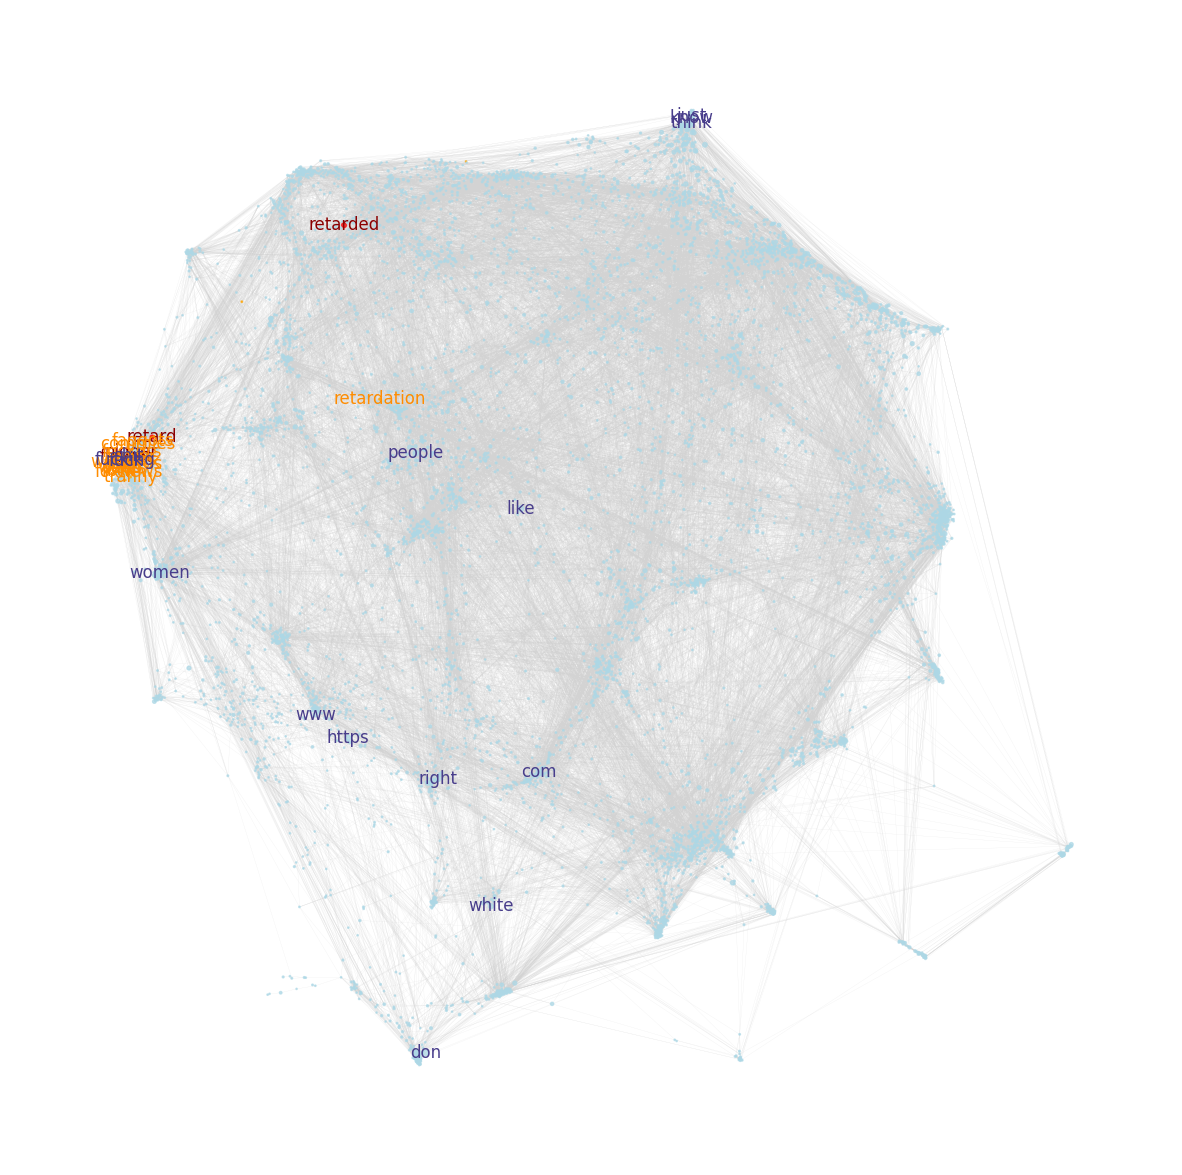

In [28]:
# visualise semantic network
lgde_300d.construct_nx_graph()
fig = lgde_300d.plot_semantic_network(n_top=15,doc_freq=list(doc_freq),lcc_only=True,node_size_factor=0.2,alpha=0.7,edge_width=0.1,plot_with_other_words=True)
fig.savefig("figures/redgab_semantic_network_300d.pdf",dpi=fig.dpi,bbox_inches="tight")

In [29]:
print("Size of semantic community of 'c**t'", len(lgde_300d.semantic_communities_["cunt"]))

Size of semantic community of 'c**t' 31


The keyword 'nigger' is a singleton semantic community.


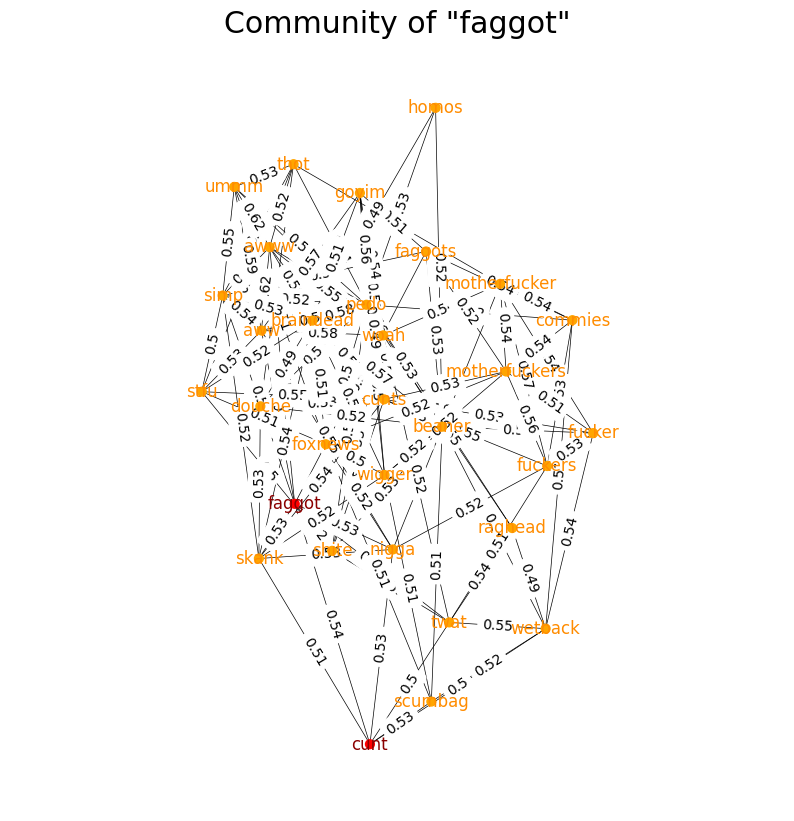

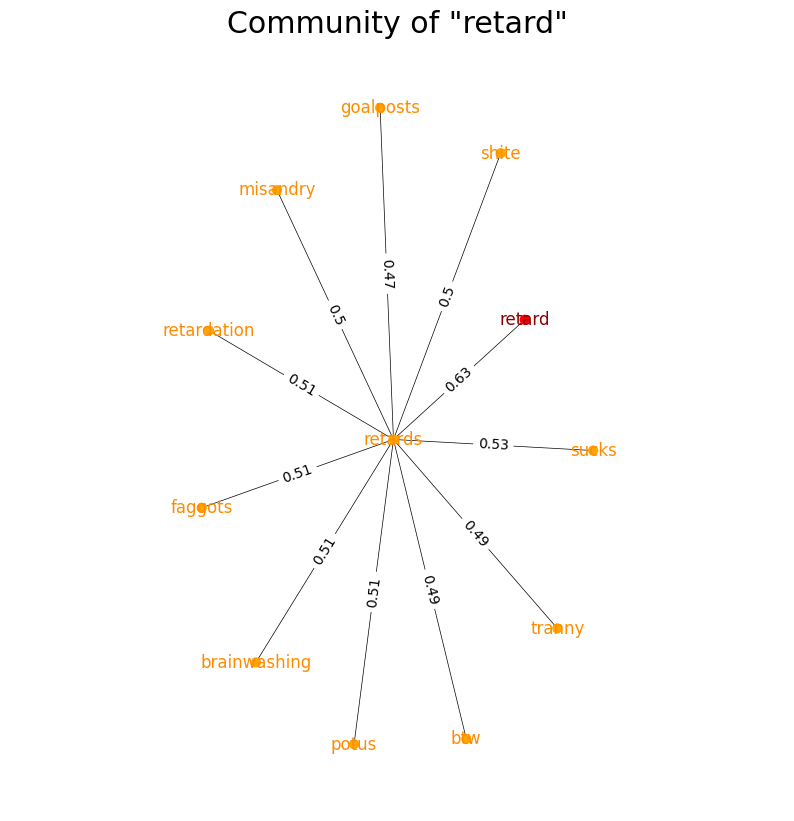

The keyword 'retarded' is a singleton semantic community.


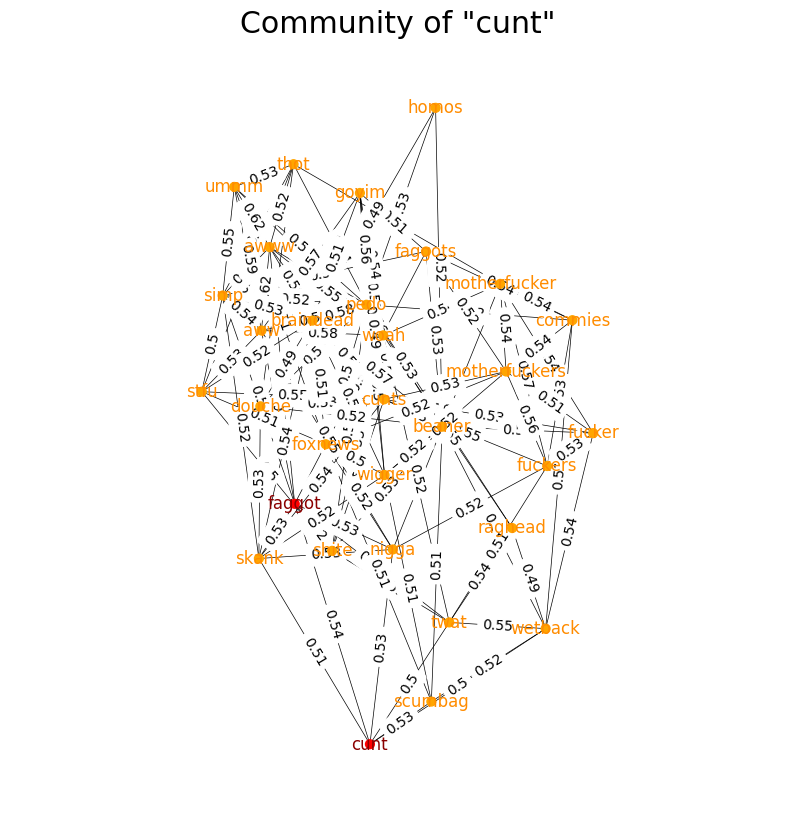

In [30]:
# plot semantic communities
lgde_300d.plot_semantic_communities(n_plots=5,figsize=(10,10),path="figures/300d-")

### 7.6) Significance tests

In [31]:
# get thresholding of same size as LGDE
eps_samesize = eps[np.argmin(size_th>len(lgde_300d.discovered_dict_))]
thres_300d_prime = Thresholding(seed_dict,word_list,word_vecs_300d)
thres_300d_prime.expand(eps_samesize)

# evaluate thresholding on test data
print("\nTest scores for same size thresholding expanded dictionary at $r=300$:\n")
_,_,_ = evaluate_prediction(thres_300d_prime.expanded_dict_, y_test, dt_test)

# determine which words are only found by LGDE or thresholding
lgde_only_300 =  list(set(lgde_300d.discovered_dict_) -  set(thres_300d_prime.discovered_dict_))
thres_only_300_prime = list(set(thres_300d_prime.discovered_dict_) - set(lgde_300d.discovered_dict_))

print("\nCOMPARISON BETWEEN BEST LGDE AND BEST THRESHOLDING OF SAME SIZE")

print("\nMedian LR+ Thresholding:", round(np.median(likelihood_ratio_positive[thres_only_300_prime]),2))
print("Median LR+ LGDE:", round(np.median(likelihood_ratio_positive[lgde_only_300]),2))
U, p = mannwhitneyu(likelihood_ratio_positive[lgde_only_300],likelihood_ratio_positive[thres_only_300_prime],alternative='greater',method='exact')
print('Mann-Whitney U test with alternative "greater": p =', np.around(p,5))

# free up memory
del thres_300d_prime
del thres_only_300_prime


Test scores for same size thresholding expanded dictionary at $r=300$:

              precision    recall  f1-score   support

       False      0.892     0.859     0.875      9057
        True      0.760     0.811     0.784      4968

    accuracy                          0.842     14025
   macro avg      0.826     0.835     0.830     14025
weighted avg      0.845     0.842     0.843     14025


COMPARISON BETWEEN BEST LGDE AND BEST THRESHOLDING OF SAME SIZE

Median LR+ Thresholding: 1.25
Median LR+ LGDE: 2.66
Mann-Whitney U test with alternative "greater": p = 0.02357


In [32]:
#######
# kNN #
#######

# get kNN of same size as LGDE
ks_knn_samesize = ks_knn[np.argmin(np.abs(size_knn - len(lgde_300d.discovered_dict_)))]
knn_300d_prime = KNearestNeighbors(seed_dict,word_list,word_vecs_300d)
knn_300d_prime.expand(ks_knn_samesize)

# determine which words are only found by LGDE or kNN
lgde_only_300 =  list(set(lgde_300d.discovered_dict_) -  set(knn_300d_prime.discovered_dict_))
knn_only_300d_prime = list(set(knn_300d_prime.discovered_dict_) - set(lgde_300d.discovered_dict_))

print("\nCOMPARISON BETWEEN BEST LGDE AND BEST kNN OF SAME SIZE")

print("\nMedian LR+ kNN:", round(np.median(likelihood_ratio_positive[knn_only_300d_prime]),2))
print("Median LR+ LGDE:", round(np.median(likelihood_ratio_positive[lgde_only_300]),2))
U, p = mannwhitneyu(likelihood_ratio_positive[lgde_only_300],likelihood_ratio_positive[knn_only_300d_prime],alternative='greater',method='exact')
print('Mann-Whitney U test with alternative "greater": p =', np.around(p,5))

# free up memory
del knn_300d_prime

########
# IKEA #
########

# get IKEA of same size as LGDE
eps_ikea_samesize = eps_ikea[np.argmin(np.abs(size_ikea - len(lgde_300d.discovered_dict_)))] 
ikea_300d_prime = IKEA(seed_dict,word_list,word_vecs_300d)
ikea_300d_prime.expand(eps_ikea_samesize)

# determine which words are only found by LGDE or IKEA
lgde_only_300 =  list(set(lgde_300d.discovered_dict_) -  set(ikea_300d_prime.discovered_dict_))
ikea_only_300d_prime = list(set(ikea_300d_prime.discovered_dict_) - set(lgde_300d.discovered_dict_))

print("\nCOMPARISON BETWEEN BEST LGDE AND BEST IKEA OF SAME SIZE")

print("\nMedian LR+ IKEA:", round(np.median(likelihood_ratio_positive[ikea_only_300d_prime]),2))
print("Median LR+ LGDE:", round(np.median(likelihood_ratio_positive[lgde_only_300]),2))
U, p = mannwhitneyu(likelihood_ratio_positive[lgde_only_300],likelihood_ratio_positive[ikea_only_300d_prime],alternative='greater',method='exact')
print('Mann-Whitney U test with alternative "greater": p =', np.around(p,5))

# free up memory
del ikea_300d_prime

############
# TextRank #
############

# get TextRank of same size as LGDE
ind_tr_samesize = np.argmin(np.abs(size_tr[ind_tr[0]] - len(lgde_300d.discovered_dict_)))
tr_300d_prime = discovered_dicts_tr[ind_tr[0]][ind_tr_samesize]

# determine which words are only found by LGDE or TextRank
lgde_only_300 =  list(set(lgde_300d.discovered_dict_) -  set(tr_300d_prime))
tr_only_300d_prime = list(set(tr_300d_prime) - set(lgde_300d.discovered_dict_))

print("\nCOMPARISON BETWEEN BEST LGDE AND BEST TextRank OF SAME SIZE")

print("\nMedian LR+ TextRank:", round(np.median(likelihood_ratio_positive[tr_only_300d_prime]),2))
print("Median LR+ LGDE:", round(np.median(likelihood_ratio_positive[lgde_only_300]),2))
U, p = mannwhitneyu(likelihood_ratio_positive[lgde_only_300],likelihood_ratio_positive[tr_only_300d_prime],alternative='greater',method='exact')
print('Mann-Whitney U test with alternative "greater": p =', np.around(p,7))


COMPARISON BETWEEN BEST LGDE AND BEST kNN OF SAME SIZE

Median LR+ kNN: 1.55
Median LR+ LGDE: 2.73
Mann-Whitney U test with alternative "greater": p = 0.10514

COMPARISON BETWEEN BEST LGDE AND BEST IKEA OF SAME SIZE

Median LR+ IKEA: 1.44
Median LR+ LGDE: 2.97
Mann-Whitney U test with alternative "greater": p = 0.00498

COMPARISON BETWEEN BEST LGDE AND BEST TextRank OF SAME SIZE

Median LR+ TextRank: 0.98
Median LR+ LGDE: 2.97
Mann-Whitney U test with alternative "greater": p = 1.38e-05
